# Jupyter Notebook - Projet Banklytics
Ce projet s’appuie sur la méthodologie CRISP-ML, une adaptation moderne du standard CRISP-DM, spécifiquement conçue pour encadrer les projets de machine learning déployés en environnement réel. Cette approche intègre non seulement les étapes classiques de compréhension métier, de préparation des données, de modélisation et d’évaluation, mais elle met également l’accent sur les dimensions opérationnelles essentielles telles que le déploiement, le monitoring et la gouvernance du modèle. À chaque étape, les exigences métier, techniques et réglementaires ont été prises en compte. Le pipeline de traitement a été industrialisé à l’aide de Scikit-Learn, et l’optimisation des hyperparamètres a été confiée à Optuna afin d'assurer la robustesse et la performance du modèle en production. En intégrant les principes de CRISP-ML, ce projet garantit une solution alignée avec les bonnes pratiques de l’industrie, adaptée aux contraintes du secteur bancaire et pensée pour un déploiement durable et responsable.

## Phase d’idéation : Business & Data Understanding

### Contexte métier
Banklytics est une banque nord-américaine active sur le marché des prêts hypothécaires. Dans un contexte de digitalisation croissante des services financiers, l’institution souhaite renforcer la rigueur de son processus d’évaluation immobilière. Actuellement, l’estimation de la valeur d’un bien proposé en garantie repose en partie sur le prix de vente déclaré par l’emprunteur et sur une expertise humaine, ce qui peut induire des biais ou des erreurs. Une surestimation expose la banque à un risque financier en cas de défaut, tandis qu’une sous-estimation peut nuire à l’expérience client et faire perdre des opportunités commerciales.

### Objectif du projet
Le projet vise à développer un modèle de régression supervisée permettant de prédire, à partir des caractéristiques objectives du bien, sa valeur de marché estimée. L’outil servira de référence neutre et reproductible pour les analystes d’octroi de crédit, dans le but de :

- Renforcer l’objectivité des décisions ;
- Réduire les écarts entre analystes ;
- Détecter plus rapidement les anomalies ;
- Accélérer le traitement des demandes standards.

Le modèle ne sera pas utilisé pour automatiser la décision, mais pour outiller l’expert humain.

### Origine et nature des données
Les données utilisées dans ce projet seront issues principalement des **dossiers techniques de prêts hypothécaires** déjà traités par Banklytics. Chaque dossier contiendra des informations structurées sur les biens immobiliers financés, telles que la surface habitable, le nombre de pièces, l’année de construction, l’état général, ou encore la présence d’annexes (garage, sous-sol, etc.), ainsi que la valeur d’expertise certifiée au moment de l’octroi du crédit.

Ces données internes seront nettoyées, anonymisées et consolidées afin de garantir la conformité aux exigences réglementaires (notamment en matière de protection des données personnelles) et de constituer un jeu d’apprentissage statistiquement fiable. Ce jeu sera ensuite enrichi par des données publiques ouvertes, telles que les registres cadastraux, les caractéristiques du quartier ou encore des indicateurs socio-économiques (revenu médian, densité de population), issus de sources officielles fiables.

L’ensemble constituera une base de données propriétaire de haute qualité, représentative du marché cible nord-américain. Cette approche permettra à la banque de disposer d’un socle de données robuste, légalement exploitable, et directement pertinent pour entraîner un modèle d’estimation fiable de la valeur immobilière.

### Critères de succès métier
Le projet vise à améliorer l'efficacité du processus d'évaluation des biens immobiliers dans le cadre de l'octroi de prêts hypothécaires. Pour mesurer son impact, plusieurs objectifs concrets ont été définis, chacun lié à un indicateur de performance clair.

- **Moins de réévaluations manuelles** : en proposant une estimation automatique fiable, le modèle devrait permettre de réduire de 15 % le nombre de dossiers qui doivent être vérifiés à nouveau à cause d’un écart trop grand entre le prix déclaré et la valeur estimée.

- **Gain de temps pour les analystes** : sur les dossiers standards, le système devrait permettre de réduire de 20 % le temps de traitement, en évitant les vérifications inutiles et en accélérant les étapes de validation.

- **Adoption de l’outil par les utilisateurs** : l’objectif est que 90 % des analystes crédit utilisent l’outil dans les 6 mois après sa mise en place, ce qui montre que l’intégration dans les processus métiers est réussie.

- **Plus de transparence pour les clients** : avec les explications générées par le modèle (grâce à SHAP), les analystes pourront mieux justifier les estimations, ce qui renforce la confiance du client dans le processus.

- **Amélioration de la satisfaction client** : une enquête après l’octroi du crédit permettra de vérifier si les clients comprennent mieux comment la valeur de leur bien a été estimée, ce qui devrait améliorer leur ressenti global sur la procédure.

### Critère de succès techniques
Le modèle est évalué à l’aide d’un seul indicateur : le **RMSLE** (Root Mean Squared Logarithmic Error). Ce choix est directement lié aux besoins de la banque dans l’évaluation des biens immobiliers.

Le RMSLE mesure les erreurs de façon relative. Cela veut dire qu’il tient compte de l’écart entre la prédiction et la valeur réelle, en fonction du prix réel du bien. Par exemple, une erreur de CHF 50’000 n’a pas le même impact pour un bien de CHF 200’000 que pour un bien de CHF 1'500’000. C’est important pour s’assurer que l’estimation est juste, peu importe le type de bien.

De plus, comme cette métrique utilise une transformation logarithmique, elle est moins sensible aux valeurs extrêmes (outliers). Cela aide le modèle à rester stable même si certaines données sont très différentes des autres. Cela va dans le sens de l’objectif métier de réduire le besoin de vérifications manuelles, surtout sur les cas inhabituels.

Enfin, le RMSLE pénalise plus les sous-estimations que les surévaluations. Pour la banque, il vaut mieux sous-estimer légèrement un bien (ce qui réduit le montant du prêt) que le surévaluer (ce qui augmente le risque si le client ne rembourse pas). Ce choix soutient donc l’objectif de maîtriser le risque de crédit.

En résumé, le RMSLE a été choisi parce qu’il permet de mesurer la qualité des prédictions d’une façon qui correspond directement aux priorités du métier : fiabilité, prudence et efficacité.

### Qualité des données et risques identifiés
L’analyse exploratoire a permis d’identifier plusieurs enjeux de qualité :

Données manquantes sur certaines variables (ex. : surface du garage, année de rénovation) ;

Présence d’outliers extrêmes (ex. : biens de luxe) pouvant fausser la régression classique ;

Variables très asymétriques comme SalePrice, justifiant une transformation logarithmique pour la cible.

Des techniques adaptées ont été intégrées au pipeline de traitement : imputation par médiane, transformation log1p, encodage One-Hot pour les variables catégorielles.

Variables clés identifiées
L’analyse exploratoire des corrélations et de la variance expliquée a permis de dégager les variables suivantes comme les plus prédictives :

GrLivArea (surface habitable en pieds carrés)

OverallQual (qualité générale perçue du bien)

YearBuilt (année de construction)

GarageArea (surface du garage)

Neighborhood (quartier)

Configuration de l'environnement et des différents imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge


import xgboost as xgb
import optuna

import mlflow

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fonctions utilisées

In [2]:
# Display missing values
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

In [3]:
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted) :
    return np.sqrt(mean_squared_error(actual, predicted))

## 1. Phase d'Idéation : Compréhension du Contexte et des Données

In [4]:
# 1.1 Chargement des données
try:
    train_df = pd.read_csv('train.csv', index_col = 'Id')
    test_df = pd.read_csv('test.csv', index_col = 'Id')
    print(f"Données d'entraînement chargées : {train_df.shape}")
    print(f"Données de test chargées : {test_df.shape}")
except FileNotFoundError:
    print("Erreur : Assurez-vous que les fichiers 'train.csv' et 'test.csv' sont présents.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()


Données d'entraînement chargées : (1460, 80)
Données de test chargées : (1459, 79)


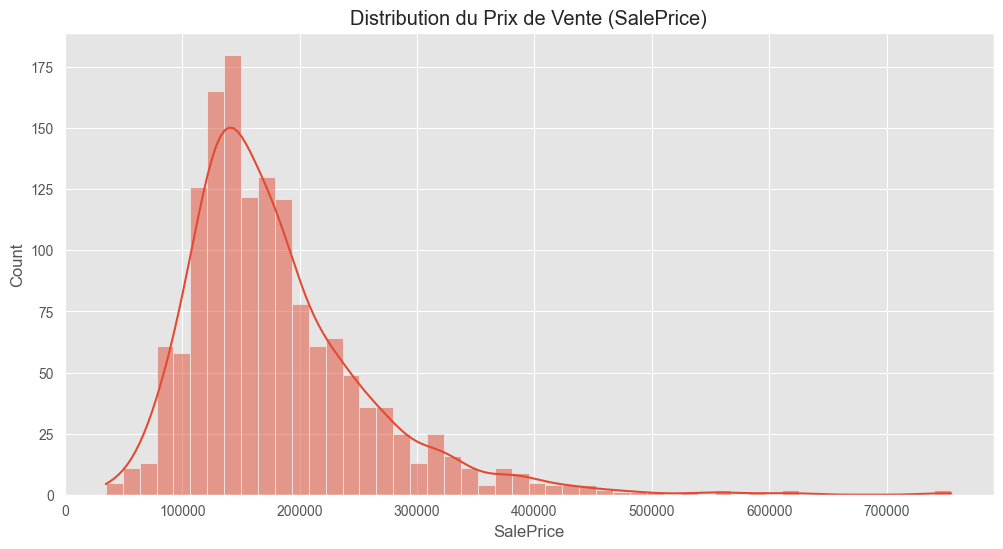

Asymétrie (Skewness) du prix de vente : 1.88
La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.


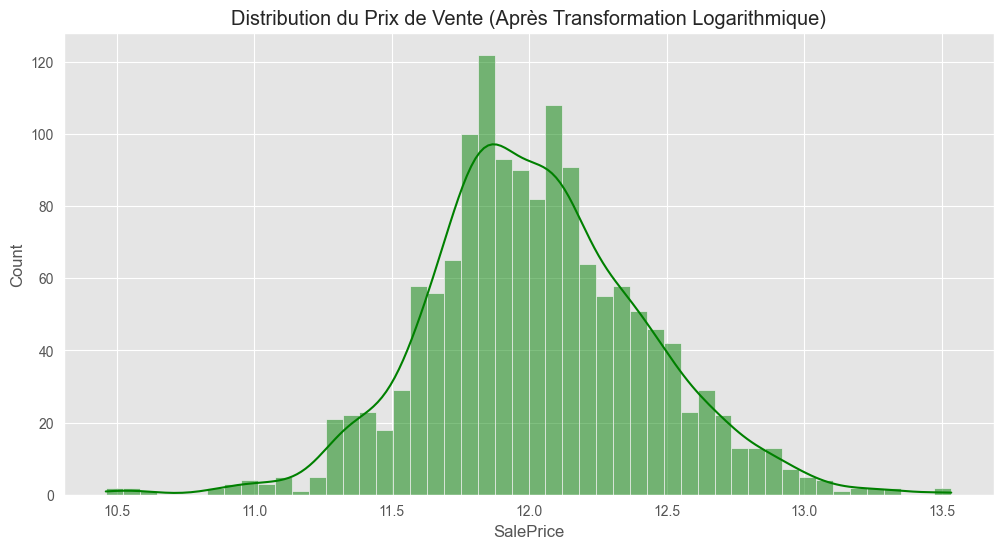

Asymétrie après transformation : 0.12


In [5]:
# 1.2 Analyse Exploratoire des Données (EDA)
if 'SalePrice' in train_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df['SalePrice'], kde=True, bins=50)
    plt.title('Distribution du Prix de Vente (SalePrice)')
    plt.show()
    print(f"Asymétrie (Skewness) du prix de vente : {train_df['SalePrice'].skew():.2f}")
    print("La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.")

    target = np.log1p(train_df["SalePrice"])

    plt.figure(figsize=(12, 6))
    sns.histplot(target, kde=True, bins=50, color='green')
    plt.title('Distribution du Prix de Vente (Après Transformation Logarithmique)')
    plt.show()
    print(f"Asymétrie après transformation : {target.skew():.2f}")

Il convient maintenant de nous intéresser de plus près aux données que nous avons à disposition afin de créer nos modèles. Nous allons dans un premier temps les diviser en trois catégories :
- Les données qualitatives
- Les données quantitatives
- Les dates



In [6]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

Une fois la catégorisation effectuée, nous avons controlé la qualité du dataset sur lequel nous allons entrainer nos modèles et certaines données sont manquantes ou alors non utilisables en l'état. Nous devons alors les nettoyer et les rendre utilisables par nos modèles. Afin de garder une cohérence, nous allons concaténer les données d'entrainements ainsi que les données de test pour être sur de traiter les données de la même manière.

Faisons dans un premier temps l'état des lieux des différentes valeurs que l'on pourrait qualifier de manquantes.

In [7]:
data_df = pd.concat([train_df, test_df])

Nombre de données quantitatives manquantes


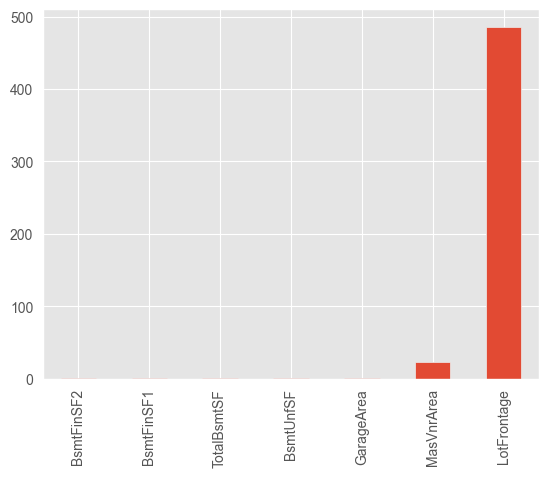

In [8]:
print(f"Nombre de données quantitatives manquantes")
plot_missing(data_df[quantitative])

Nombre de données qualitatives manquantes


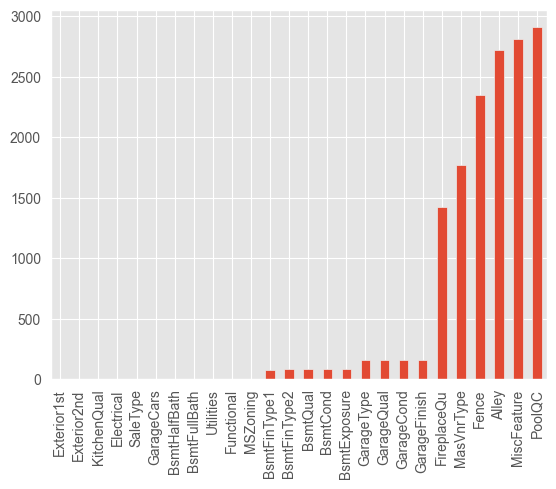

In [9]:
print(f"Nombre de données qualitatives manquantes")
plot_missing(data_df[qualitative])

Nombre de données dates manquantes


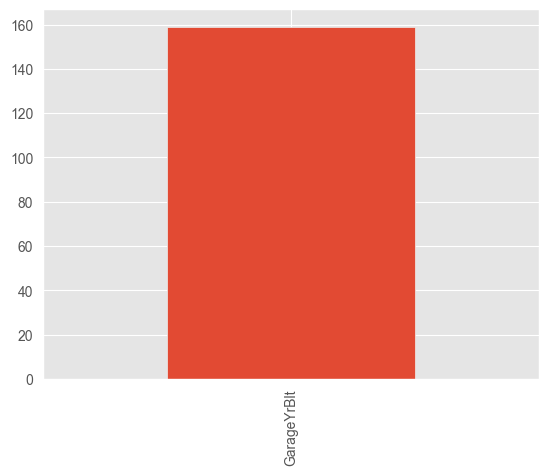

In [10]:
print(f"Nombre de données dates manquantes")
plot_missing(data_df[date])

Nous ne pouvons pas laisser ces données comme ça car elles seront inexploitable par le modèle. Par conséquent, en fonction du type de données nous allons devoir interpreter ce cela veut signifer. Par exemple, en ce qui concerne la donnée LotFrontage, NA signifie qu'il n'y a pas de rue collée à la propriété. Comme LotFrontage est une valeur quantitative, nous pouvons alors remplacé ce NA par 0 ce qui permettra au modèle de comprendre la donnée sans pour autant perdre l'information qu'elle représente.  
  
Certaines valeurs qualitatives comme GarageType ont également des données manquantes notées NA dans notre dataset cependant nous devons les traiter différemment puisqu'il s'agit de données qualitative. Nous avons décider de laisser NA pour toutes les données qualitatives et nous savons que cette notation n'indique pas l'absence de données (null) mais bien une information qui a été recensée.  
  
Concernant les colonnes de types date, seul GarageYrBlt contient des valeurs NA. Afin d'unifier cette donnée, nous avons décidé de remplacer par le valeur -1 qui consisteraient à indiquer l'absence de garage.

In [11]:
# Function to fill missing data with a constant value
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

In [12]:
def fill_missing_with_column(data, missing, column) :
    
    data_clean = data.copy()
    
    data_clean[missing] = np.where(data_clean[missing].isnull(), data_clean[column], data_clean[missing])
    
    return data_clean

Etant donné l'écart des années de ventes dans notre dataset, il nous faut convertir les différentes colonnes de dates (`YearBuilt`, `YearRemodAdd`, et `GarageYrBlt`) en durée afin d'unifier les durées entre l'année de vente et les différentes dates.

In [13]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

In [14]:
def clean(data) :
    
    data_clean = data.copy()
    
    # imputing missing variables
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_column(data_clean, missing = ['GarageYrBlt'], column = ['YearBuilt'])

    # transform date columns
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

In [15]:
data_clean_df = clean(data_df)
train_clean_df = clean(train_df)
test_clean_df = clean(test_df)

## Modèle Baseline et choix des variables pour ce dernier  

Afin de pouvoir créer un modèle Baseline simple, nous devons séléctionner les variables qui vont être le plus correlées avec le logarithme du prix de vente.  
  
Pour se faire, nous devons encoder les variables qualitatives en variable numériques afin de calculer leur corrélation. Une solution à ce problème serait de remplacer la variable par la moyenne de la variable cible associée. Ceci entrainera donc une correlation entre la variable qualitative et la nouvelle variable créée.

In [16]:
def encode_with_mean(data, target, features):
    
    data_preprocess = data.copy()
    
    for f in features: 
        
        # create a temporary dataframe for our workload
        frame = pd.DataFrame()
        frame[f] = data[f].copy()
        frame[target.name] = target.copy()
        
        # create the mapping table
        mapping = pd.DataFrame()
        mapping['val'] = data[f].unique()
        mapping.index = mapping.val
        
        # compute the mean of our target variable for each category
        mapping['mean'] = frame[[f, target.name]].groupby(f).mean()[target.name]
        
        # if a category has NA, we shall simply put the mean value
        mapping['mean'] = mapping['mean'].fillna(target.mean())

        # we replace the feature with the means in the mapping table
        data_preprocess[f] = pd.merge(data_preprocess, mapping, left_on = f, right_index = True)['mean'].copy()
        
    return data_preprocess

In [17]:
#Function to calculate the correlation of Pearson between a target variable and features
def correlation(y, X, features, method = 'pearson'):
    
    cor = pd.DataFrame()
    cor['feature'] = features
    
    cor['correlation_coef'] = [X[f].corr(y, method = method) for f in features]
    cor['correlation_coef'] = cor['correlation_coef'].fillna(0)
    cor['correlation_coef_abs'] = cor['correlation_coef'].abs()
    
    cor = cor.sort_values('correlation_coef', ascending = False)

    plt.figure(figsize=(10, 0.25*len(features)))
    sns.barplot(data = cor, y = 'feature', x = 'correlation_coef', orient = 'h')
    
    return cor

,feature,correlation_coef,correlation_coef_abs
56,OverallQual,0.817185,0.817185
9,Neighborhood,0.755518,0.755518
66,GrLivArea,0.700927,0.700927
44,GarageCars,0.700078,0.700078
19,ExterQual,0.679060,0.679060
...,...,...,...
65,LowQualFinSF,-0.037963,0.037963
70,EnclosedPorch,-0.149050,0.149050
76,YearRemodAdd,-0.568136,0.568136
78,GarageYrBlt,-0.569568,0.569568


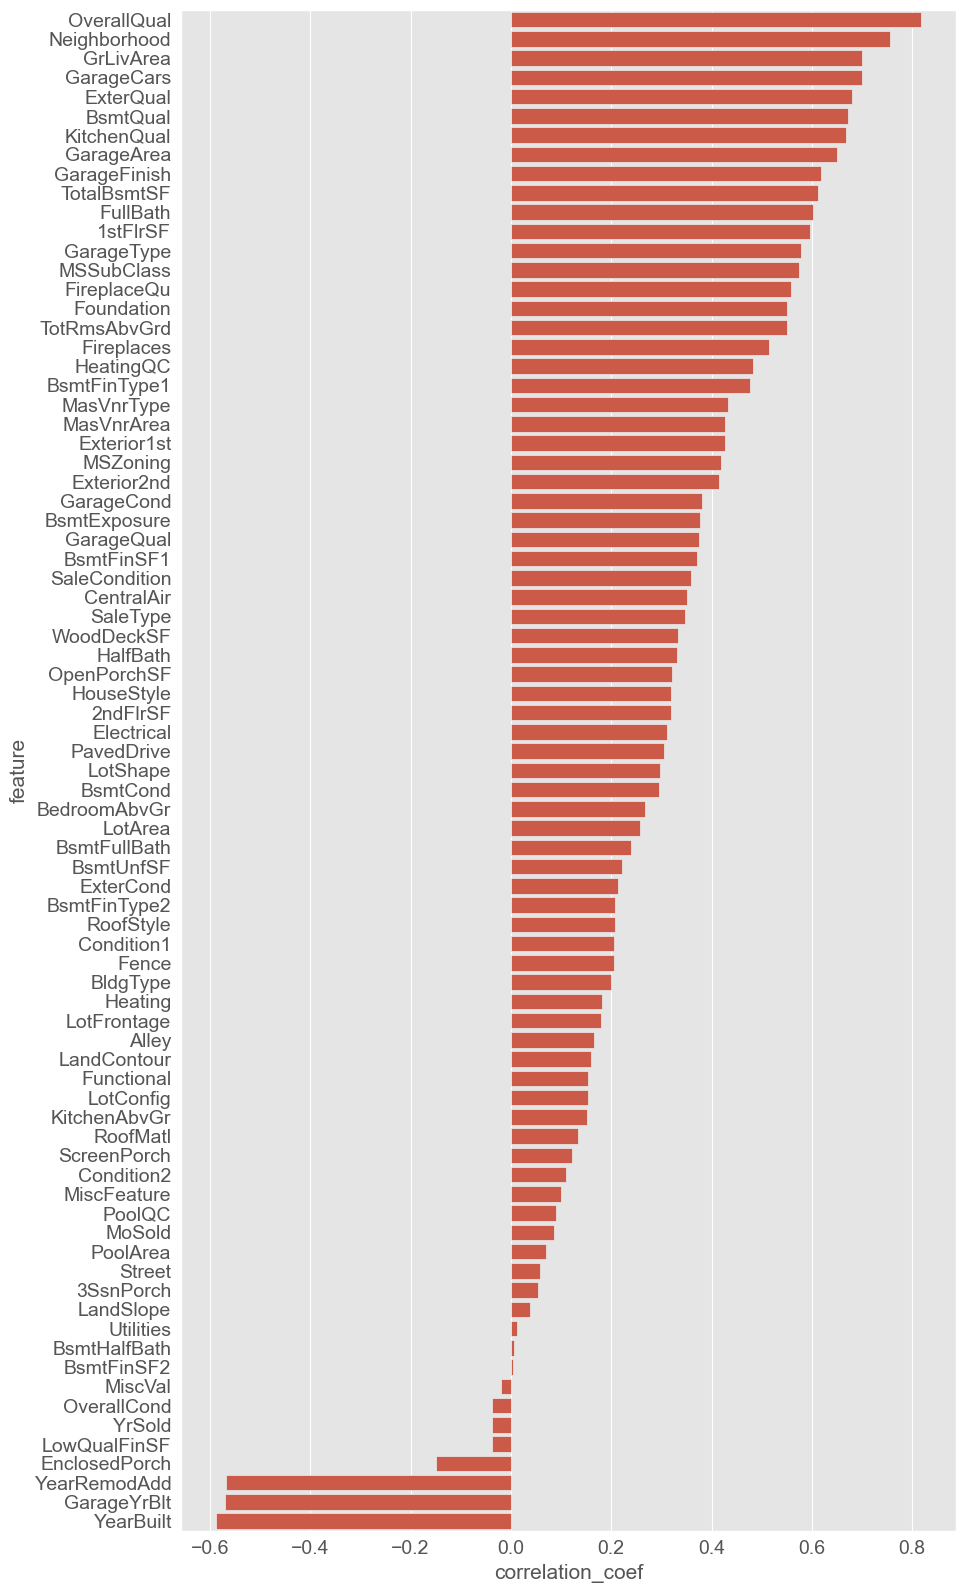

In [29]:
data_preprocess = encode_with_mean(data_clean_df, target, qualitative)

# Split of the clean dataset into train & validation
train_preprocess = data_preprocess[data_preprocess.index.isin(train_df.index)]
validation_preprocess = data_preprocess[data_preprocess.index.isin(test_df.index)]

cor = correlation(target, train_preprocess, qualitative + quantitative + date)
cor

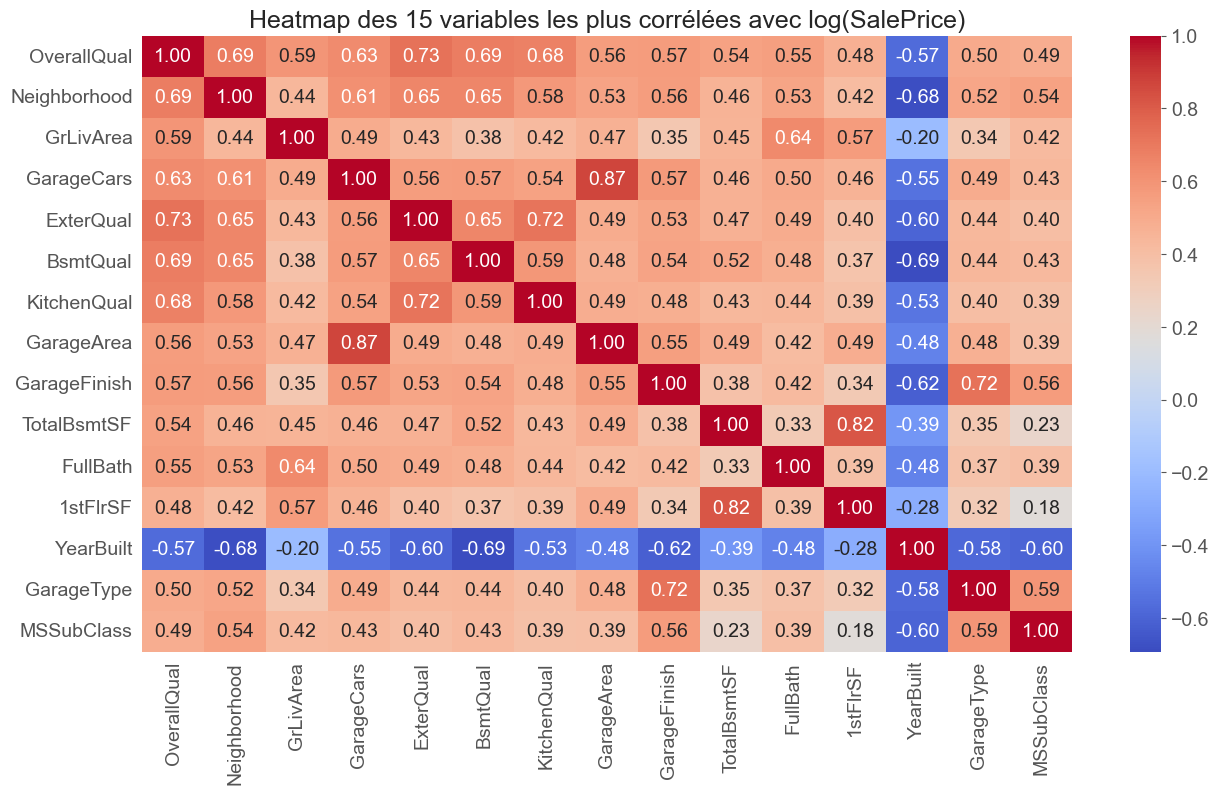

In [30]:
# Sélectionne les 10 variables avec la plus forte corrélation absolue
top15 = cor.sort_values('correlation_coef_abs', ascending=False).head(15)['feature'].tolist()
# Sous-ensemble du DataFrame train_preprocess avec ces variables
df_top10 = train_preprocess[top15]

# Affiche la heatmap de corrélation
plt.figure(figsize=(15, 8))
sns.heatmap(df_top10.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap des 15 variables les plus corrélées avec log(SalePrice)")
plt.show()

Nous allons donc séléctionner cinq variables afin de créer notre baseline. D'après les données de correlations ci-dessus ainsi que notre compréhension du métier et du domaine immobilier, les variables suivantes ont retenues notre attention.  
- `OverallQual`, correlation de 0.82
- `Neighborhood`, correlation de 0.76
- `GrLivArea`, correlation de 0.70
- `TotalBsmtSF`, correlation de 0.61
- `YearBuilt`, correlation de -0.59

Ces variables sont assez communes lors de la recherche d'un logement et représentent plus ou moins les critères de bases. En ce qui concerne la cave, il s'agit d'un point assez essentiel au vu de la situation géographique de Ames car elle se situe en plein milieu du couloir des tornades (zone géographique des États-Unis fréquemment touchée par ce phénomène).
  
Notre baseline reposera donc sur ces cinq variables et nous appliqueronns la regréssion linéaire afin de faire notre modèle.

In [31]:
base = ['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']


X = train_preprocess[base]
x_test = validation_preprocess[base]
y = target


model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1367.
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        09:58:01   Log-Likelihood:                 539.40
No. Observations:                1460   AIC:                            -1067.
Df Residuals:                    1454   BIC:                            -1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8392      0.271     25.244   

Voici les assomptions pour la régression linéaire, en indiquant avec quel graphique nous allons les tester :
- Linéarité de la relation entre les variables explicatives et la variable cible -> Residuals vs Fitted
- Les résultats sont normalements distribués autour de 0 -> Normal Q-Q Plot
- Homoscédasticité des résidus (variance constante) -> Scale-Location Plot
- Absence de points influents démesurés -> Residuals vs Leverage
- Absence d'outliers dans les résidus (erreurs extrêmes) -> visible dans plusieurs graphes, notamment Q-Q Plot et Cook’s Distance

In [32]:
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]))
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals')
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]))
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]))
    
    plot_lm_4 = plt.figure()
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]))
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right')

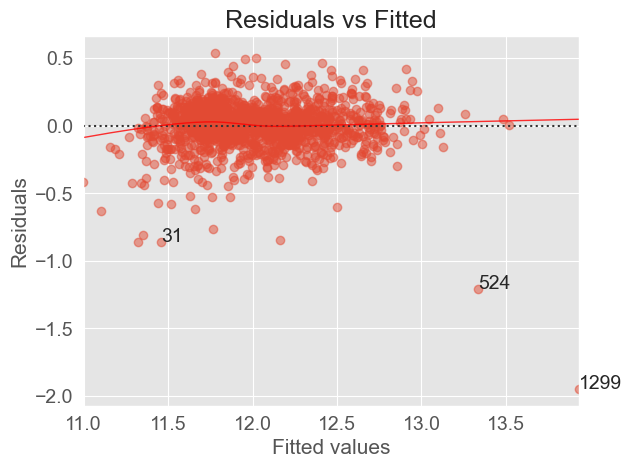

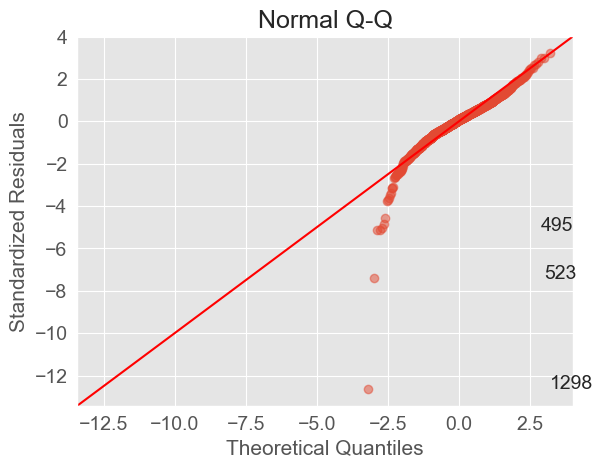

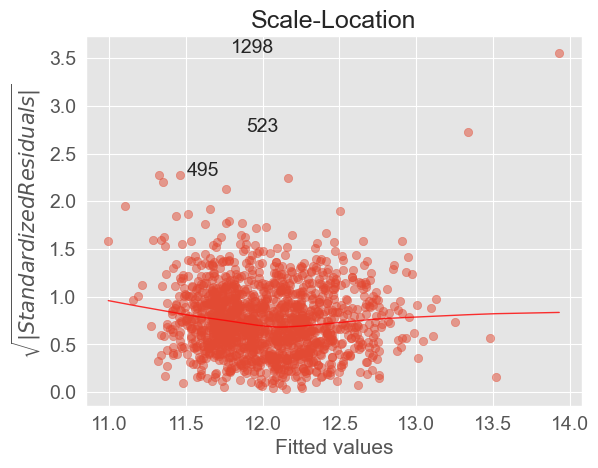

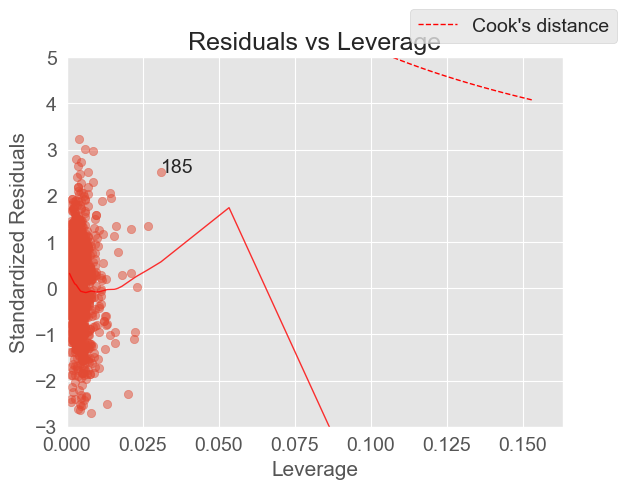

In [33]:
diagnostic_plots(sm.add_constant(X), y)

Nous voyons qu'il existe quelques valeurs extrêmes que les graphes ci-dessus ont mis en lumière. Il convient de les traiter afin qu'ils ne pejorent pas notre modèle. Un des critères sur lequel se baser pour éliminer une partie des ces valeurs extrêmes est la taille de la maison. En effet, par convention, les biens ayant une superficie habitable de plus de 4000 pieds carré sont extrêmement rares et ne sont pas représentatifs du marché.

Nous supprimons donc ces données extrêmes.

In [34]:
print(train_df[base].iloc[[31, 185, 495, 523, 524, 1298, 1299]])

      OverallQual Neighborhood  GrLivArea  TotalBsmtSF  YearBuilt
Id                                                               
32              5       Sawyer       1228         1228       1966
186            10      OldTown       3608         1107       1892
496             4       IDOTRR        720          720       1920
524            10      Edwards       4676         3138       2007
525             7      NoRidge       2398         1379       1996
1299           10      Edwards       5642         6110       2008
1300            5        NAmes       1246         1246       1959


In [35]:
def remove_outliers(data, target, feature):
    
    data_preprocess = data.copy()
    data_preprocess[target.name] = target.copy()
    
    #Compute interquartile range
    q1 = data_preprocess[feature].quantile(0.25)
    q3 = data_preprocess[feature].quantile(0.75)
    
    iqr = q3-q1 
    
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    data_preprocess = data_preprocess.loc[(data_preprocess[feature] > fence_low) & (data_preprocess[feature] < fence_high)]
    
    return data_preprocess[data.columns], data_preprocess[target.name]

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1522.
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        09:58:57   Log-Likelihood:                 659.93
No. Observations:                1429   AIC:                            -1308.
Df Residuals:                    1423   BIC:                            -1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.7556      0.257     30.195   

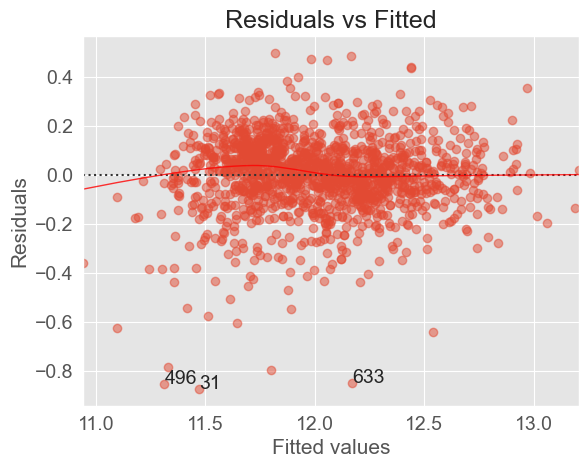

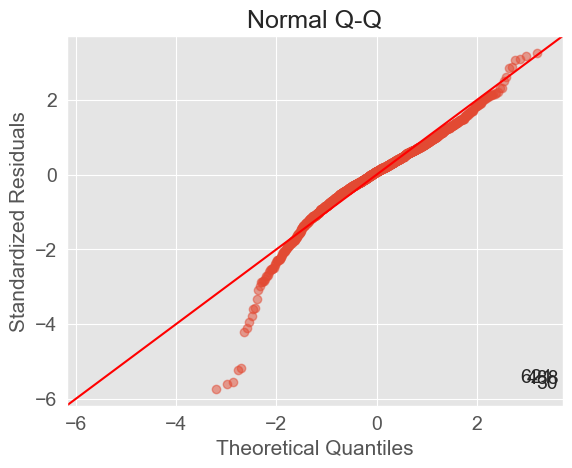

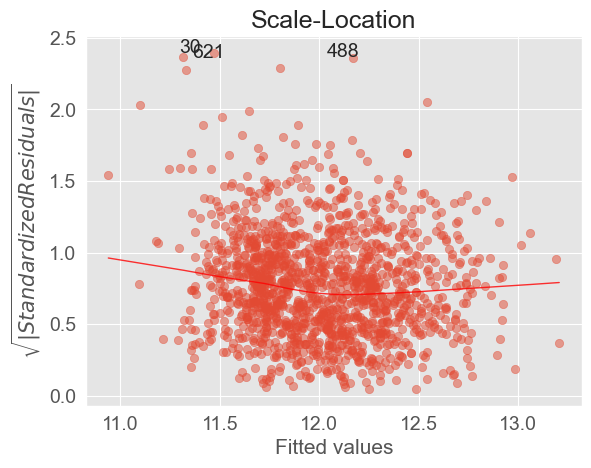

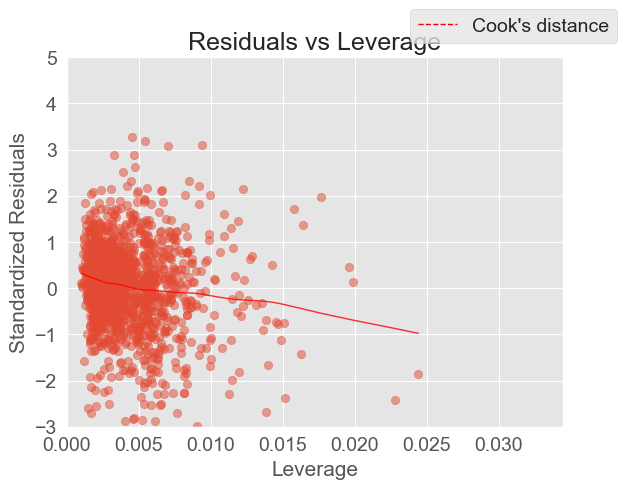

In [36]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

Notre modèle semble mieux se comporter sans ces valeurs extrêmes. Il semble être convaincant pour notre baseline. Nous allons donc calculer le RMSE basé sur notre target (le log de SalePrice)

In [37]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.214534
2    12.081588
3    12.244451
4    12.046219
5    12.620316
dtype: float64


In [38]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.1524750806291098


In [40]:
y_pred_test = res.predict(sm.add_constant(x_test))

In [41]:
submission = pd.DataFrame()
submission['Id'] = y_pred_test.index
submission['SalePrice'] = np.expm1(y_pred_test.values)

submission.to_csv('Data/baselineV2.csv', index = False)

## 2. Phase de Design : Ingénierie des Données et Pipeline de Modélisation

In [42]:
# Séparation des features (X) et de la cible (y)
if 'SalePrice' in train_df.columns:
    X = train_df.drop('SalePrice', axis=1)
    y = train_df['SalePrice']
    X_test = test_df.copy()

# Ingénierie des Features
all_data = pd.concat([X, X_test], axis=0)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.5].index
lam = 0.15
for feat in skewed_feats:
    all_data[feat] = boxcox1p(all_data[feat], lam)

X = all_data.iloc[:len(y)]
X_test = all_data.iloc[len(y):]

Afin de s'assurer que nos données puissent être comprises et utilisées par notre modèle, il est primordial de créer une pipeline capable d'effectuer les transformations nécessaires de manières justes et systématiques.  

Dans notre cas, nous avons identifié trois types de données différents, les données quantitatives, les données qualitatives et les dates ou données temporelles. Il nous faudra donc créer des ColumnTransformer pour chacune de ces trois catégories.  

Il nous faudra également s'assurer de la qualité de nos données et ainsi "combler" les valeurs manquantes.
- Pour les valeurs quantitative, nous avons utilisé la stratégie de la médiane
- Pour les valeurs qualitative, nous avons utilisé la stratégie dite "Most frequent"

-- Parler du One-Hot encoder

Enfin, il nous a fallu gérer les valeurs extrêmes, liées à GrLivArea, pour ça nous allons donc retiré les valeurs à l'aide de la fonction défini plus haut

In [43]:
#Pipeline de prétraitement
#Gestion des dates, transformation en durées relatives
def compute_relative_dates(df):
    df = df.copy()
    df['YearsSinceBuilt'] = df['YrSold'] - df['YearBuilt']
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['YearsSinceGarage'] = df['YrSold'] - df['GarageYrBlt'].fillna(df['YearBuilt'])
    return df[['YearsSinceBuilt', 'YearsSinceRemod', 'YearsSinceGarage']]

date_transformer = Pipeline(steps=[
    ('relativedates', FunctionTransformer(compute_relative_dates, validate=False))
])

#Gestion des valeurs qunantitatives manquantes (median)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

#Gestion des valeurs qualitatives manquantes (most_frequent) et encodage one-hot

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Assemblage des transformations dans un préprocesseur

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, quantitative),
    ('cat', categorical_transformer, qualitative),
    ('dates', date_transformer, date)
], remainder='drop')

X_train = train_df.copy()
X_test = test_df.copy()
y_train = target.copy()

#Suppression des valeurs extrêmes

outliers_ids = train_df.index[(train_df['GrLivArea'] > 4000)]

X_train = X_train.drop(index=outliers_ids)
y_train = y_train.drop(index=outliers_ids)

#Pipeline finale

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

preprocessing_pipeline

print(f"Nombre d'observations avant suppression des outliers : {train_df.shape[0]}")
print(f"Nombre d'observations après suppression : {X_train.shape[0]}")
print(f"Outliers supprimés : {len(outliers_ids)}")

Nombre d'observations avant suppression des outliers : 1460
Nombre d'observations après suppression : 1456
Outliers supprimés : 4


In [47]:
def random_forest_objective(trial, preprocessing_pipeline, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),
        'max_depth': trial.suggest_int('max_depth', 10, 40, log=True),
        'min_samples_split': trial.suggest_float('min_samples_split', 1e-5, 0.01, log=True),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 1e-6, 1e-4, log=True),
        'max_features': trial.suggest_float('max_features', 0.1, 0.8)
    }
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    return -score


def ridge_objective(trial, preprocessing_pipeline, X, y):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "solver": trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sag", "saga"]),
        "random_state": 42,
    }
    model = Ridge(**params)
    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    return -score

def xgBoost_objective(trial, preprocessing_pipeline, X, y):
    params = {
        "eta": trial.suggest_float("eta", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "alpha": trial.suggest_float("alpha", 1e-6, 10, log=True),
        "lambda": trial.suggest_float("lambda", 1e-6, 10, log=True),
        "random_state": 42,
    }
    model = xgb.XGBRegressor(objective="reg:squarederror", **params)
    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    return -score


## 3. Phase de Validation : Optimisation des Hyperparamètres avec Optuna

In [52]:
def optimize_models(models_dict, X, y, preprocessing_pipeline, n_trials=40):
    """
    Optimise plusieurs modèles avec Optuna.
    Args:
        models_dict: dict, clé = nom du modèle, valeur = fonction objective(trial)
        n_trials: nombre d'essais Optuna par modèle
        timeout: temps max par modèle (en secondes)
    Returns:
        results: dict, clé = nom du modèle, valeur = (best_score, best_params, study)
    """

    results = {}
    for name, objective in models_dict.items():
        print(f"\n--- Optimisation {name} ---")

        def wrapped_objective(trial):
            return objective(trial, preprocessing_pipeline, X, y)
        
        study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42), study_name=name)
        study.optimize(wrapped_objective, n_trials=n_trials, show_progress_bar=True)
        print(f"Meilleur score {name}: {study.best_value:.5f}")
        print("Meilleurs hyperparamètres:", study.best_params)
        results[name] = (study.best_value, study.best_params, study)


    names = list(results.keys())
    means = [results[name][0] for name in names]

    plt.figure(figsize=(10, 5))
    plt.bar(names, means, color='skyblue')
    plt.ylabel("Meilleur RMSE (CV)")
    plt.title("Comparaison des modèles optimisés")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return results

[I 2025-06-24 16:55:14,650] A new study created in memory with name: Random Forest



--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---

--- Optimisation Random Forest ---


Best trial: 0. Best value: 0.132883:   1%|          | 1/100 [00:01<02:42,  1.64s/it]

[I 2025-06-24 16:55:16,294] Trial 0 finished with value: 0.13288322398883268 and parameters: {'n_estimators': 762, 'max_depth': 38, 'min_samples_split': 0.001570297088405539, 'min_samples_leaf': 1.575132049977973e-05, 'max_features': 0.20921304830970558}. Best is trial 0 with value: 0.13288322398883268.


Best trial: 0. Best value: 0.132883:   2%|▏         | 2/100 [00:03<02:58,  1.82s/it]

[I 2025-06-24 16:55:18,234] Trial 1 finished with value: 0.1347291093811686 and parameters: {'n_estimators': 609, 'max_depth': 10, 'min_samples_split': 0.003967605077052989, 'min_samples_leaf': 1.5930522616241016e-05, 'max_features': 0.5956508044572318}. Best is trial 0 with value: 0.13288322398883268.


Best trial: 2. Best value: 0.132708:   3%|▎         | 3/100 [00:04<02:26,  1.51s/it]

[I 2025-06-24 16:55:19,377] Trial 2 finished with value: 0.13270785601769547 and parameters: {'n_estimators': 514, 'max_depth': 39, 'min_samples_split': 0.00314288089084011, 'min_samples_leaf': 2.6587543983272713e-06, 'max_features': 0.22727747704497045}. Best is trial 2 with value: 0.13270785601769547.


Best trial: 3. Best value: 0.132382:   4%|▍         | 4/100 [00:06<02:30,  1.56s/it]

[I 2025-06-24 16:55:21,022] Trial 3 finished with value: 0.13238221886793694 and parameters: {'n_estimators': 628, 'max_depth': 15, 'min_samples_split': 0.00037520558551242813, 'min_samples_leaf': 7.30953983591291e-06, 'max_features': 0.30386039813862936}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 3. Best value: 0.132382:   5%|▌         | 5/100 [00:09<03:14,  2.05s/it]

[I 2025-06-24 16:55:23,942] Trial 4 finished with value: 0.13254596426243276 and parameters: {'n_estimators': 928, 'max_depth': 12, 'min_samples_split': 7.52374288453485e-05, 'min_samples_leaf': 5.404103854647334e-06, 'max_features': 0.4192489889519252}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 3. Best value: 0.132382:   6%|▌         | 6/100 [00:10<02:56,  1.87s/it]

[I 2025-06-24 16:55:25,466] Trial 5 finished with value: 0.13524186093057475 and parameters: {'n_estimators': 1050, 'max_depth': 13, 'min_samples_split': 0.0003489018845491386, 'min_samples_leaf': 1.5304852121831454e-05, 'max_features': 0.1325152889039984}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 3. Best value: 0.132382:   7%|▋         | 7/100 [00:15<04:15,  2.75s/it]

[I 2025-06-24 16:55:30,022] Trial 6 finished with value: 0.13515565307594438 and parameters: {'n_estimators': 925, 'max_depth': 12, 'min_samples_split': 1.5673095467235405e-05, 'min_samples_leaf': 7.902619549708236e-05, 'max_features': 0.7759424231521916}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 3. Best value: 0.132382:   8%|▊         | 8/100 [00:18<04:37,  3.02s/it]

[I 2025-06-24 16:55:33,611] Trial 7 finished with value: 0.1324369422555421 and parameters: {'n_estimators': 1066, 'max_depth': 15, 'min_samples_split': 1.9634341572933304e-05, 'min_samples_leaf': 2.3359635026261618e-05, 'max_features': 0.408106745617721}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 3. Best value: 0.132382:   9%|▉         | 9/100 [00:20<03:56,  2.60s/it]

[I 2025-06-24 16:55:35,285] Trial 8 finished with value: 0.1324354280974451 and parameters: {'n_estimators': 585, 'max_depth': 19, 'min_samples_split': 1.2681352169084594e-05, 'min_samples_leaf': 6.586289317583115e-05, 'max_features': 0.2811459871200119}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 3. Best value: 0.132382:  10%|█         | 10/100 [00:22<03:41,  2.47s/it]

[I 2025-06-24 16:55:37,458] Trial 9 finished with value: 0.13284928268757965 and parameters: {'n_estimators': 964, 'max_depth': 15, 'min_samples_split': 0.00036324869566766035, 'min_samples_leaf': 1.2399967836846103e-05, 'max_features': 0.22939811886786896}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 3. Best value: 0.132382:  11%|█         | 11/100 [00:26<04:03,  2.74s/it]

[I 2025-06-24 16:55:40,823] Trial 10 finished with value: 0.13296819076793726 and parameters: {'n_estimators': 755, 'max_depth': 26, 'min_samples_split': 9.51167037069256e-05, 'min_samples_leaf': 1.0862348973937125e-06, 'max_features': 0.5599865683508487}. Best is trial 3 with value: 0.13238221886793694.


Best trial: 11. Best value: 0.132114:  12%|█▏        | 12/100 [00:28<03:40,  2.50s/it]

[I 2025-06-24 16:55:42,778] Trial 11 finished with value: 0.13211414045131825 and parameters: {'n_estimators': 649, 'max_depth': 21, 'min_samples_split': 0.0008201915027201753, 'min_samples_leaf': 7.832921114568415e-05, 'max_features': 0.322763447642603}. Best is trial 11 with value: 0.13211414045131825.


Best trial: 11. Best value: 0.132114:  13%|█▎        | 13/100 [00:30<03:29,  2.41s/it]

[I 2025-06-24 16:55:44,973] Trial 12 finished with value: 0.13215989112929863 and parameters: {'n_estimators': 696, 'max_depth': 22, 'min_samples_split': 0.0008260463847397075, 'min_samples_leaf': 6.203271813191219e-06, 'max_features': 0.3429634761593223}. Best is trial 11 with value: 0.13211414045131825.


Best trial: 13. Best value: 0.131805:  14%|█▍        | 14/100 [00:32<03:28,  2.43s/it]

[I 2025-06-24 16:55:47,438] Trial 13 finished with value: 0.13180496860790947 and parameters: {'n_estimators': 741, 'max_depth': 24, 'min_samples_split': 0.001374648808769182, 'min_samples_leaf': 4.414973500475092e-05, 'max_features': 0.3713159428447727}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  15%|█▌        | 15/100 [00:35<03:22,  2.38s/it]

[I 2025-06-24 16:55:49,718] Trial 14 finished with value: 0.1350623829542991 and parameters: {'n_estimators': 796, 'max_depth': 30, 'min_samples_split': 0.009387391391828532, 'min_samples_leaf': 3.7927492630521836e-05, 'max_features': 0.5393500616791651}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  16%|█▌        | 16/100 [00:39<04:11,  2.99s/it]

[I 2025-06-24 16:55:54,118] Trial 15 finished with value: 0.1321527246166793 and parameters: {'n_estimators': 1176, 'max_depth': 20, 'min_samples_split': 0.001050975148639631, 'min_samples_leaf': 4.107890403082426e-05, 'max_features': 0.46047928981466035}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  17%|█▋        | 17/100 [00:43<04:23,  3.18s/it]

[I 2025-06-24 16:55:57,735] Trial 16 finished with value: 0.1337845632973522 and parameters: {'n_estimators': 687, 'max_depth': 26, 'min_samples_split': 0.00012953407787792565, 'min_samples_leaf': 9.899592289761564e-05, 'max_features': 0.6907860711978367}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  18%|█▊        | 18/100 [00:44<03:31,  2.57s/it]

[I 2025-06-24 16:55:58,901] Trial 17 finished with value: 0.1361152162225951 and parameters: {'n_estimators': 823, 'max_depth': 30, 'min_samples_split': 0.0022289789879751864, 'min_samples_leaf': 4.1317312878129476e-05, 'max_features': 0.10690058532299501}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  19%|█▉        | 19/100 [00:46<03:10,  2.35s/it]

[I 2025-06-24 16:56:00,727] Trial 18 finished with value: 0.1332561415843833 and parameters: {'n_estimators': 699, 'max_depth': 18, 'min_samples_split': 0.007014867802638774, 'min_samples_leaf': 2.7910454007942164e-05, 'max_features': 0.39983198614267745}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  20%|██        | 20/100 [00:48<03:03,  2.29s/it]

[I 2025-06-24 16:56:02,878] Trial 19 finished with value: 0.13235798904025708 and parameters: {'n_estimators': 537, 'max_depth': 23, 'min_samples_split': 0.0006332118517605309, 'min_samples_leaf': 6.558509726714329e-05, 'max_features': 0.4804991771150654}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  21%|██        | 21/100 [00:51<03:13,  2.45s/it]

[I 2025-06-24 16:56:05,700] Trial 20 finished with value: 0.13230757206269805 and parameters: {'n_estimators': 894, 'max_depth': 32, 'min_samples_split': 0.00019144530822375256, 'min_samples_leaf': 5.412229229234631e-05, 'max_features': 0.3419381404459508}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  22%|██▏       | 22/100 [00:53<03:19,  2.56s/it]

[I 2025-06-24 16:56:08,519] Trial 21 finished with value: 0.13276975473272332 and parameters: {'n_estimators': 674, 'max_depth': 21, 'min_samples_split': 0.0010466834863208673, 'min_samples_leaf': 2.8270575078686252e-05, 'max_features': 0.5038644217227747}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  23%|██▎       | 23/100 [00:57<03:47,  2.95s/it]

[I 2025-06-24 16:56:12,382] Trial 22 finished with value: 0.13203306013760227 and parameters: {'n_estimators': 1175, 'max_depth': 18, 'min_samples_split': 0.0015183455660512397, 'min_samples_leaf': 4.371624742812633e-05, 'max_features': 0.37060470536351003}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  24%|██▍       | 24/100 [01:01<04:02,  3.19s/it]

[I 2025-06-24 16:56:16,144] Trial 23 finished with value: 0.1321127413981908 and parameters: {'n_estimators': 1170, 'max_depth': 17, 'min_samples_split': 0.0014945588921537474, 'min_samples_leaf': 9.922210060166456e-05, 'max_features': 0.3589988533579453}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  25%|██▌       | 25/100 [01:04<03:59,  3.20s/it]

[I 2025-06-24 16:56:19,352] Trial 24 finished with value: 0.13268453313166945 and parameters: {'n_estimators': 1200, 'max_depth': 17, 'min_samples_split': 0.004556886757791985, 'min_samples_leaf': 4.892854163218109e-05, 'max_features': 0.371546598376775}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  26%|██▌       | 26/100 [01:07<03:47,  3.08s/it]

[I 2025-06-24 16:56:22,144] Trial 25 finished with value: 0.13246319579396157 and parameters: {'n_estimators': 1132, 'max_depth': 24, 'min_samples_split': 0.0017314698333194007, 'min_samples_leaf': 9.42860976668174e-05, 'max_features': 0.2671163925101123}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  27%|██▋       | 27/100 [01:12<04:19,  3.55s/it]

[I 2025-06-24 16:56:26,806] Trial 26 finished with value: 0.13354028136882828 and parameters: {'n_estimators': 1074, 'max_depth': 17, 'min_samples_split': 0.002391178676496921, 'min_samples_leaf': 2.221740896347903e-05, 'max_features': 0.6325052818285859}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  28%|██▊       | 28/100 [01:14<03:45,  3.13s/it]

[I 2025-06-24 16:56:28,936] Trial 27 finished with value: 0.1328275727088945 and parameters: {'n_estimators': 982, 'max_depth': 16, 'min_samples_split': 0.0005858659297084497, 'min_samples_leaf': 3.5900028084738784e-05, 'max_features': 0.1870613865271684}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  29%|██▉       | 29/100 [01:18<03:56,  3.33s/it]

[I 2025-06-24 16:56:32,744] Trial 28 finished with value: 0.13253702459849553 and parameters: {'n_estimators': 1117, 'max_depth': 13, 'min_samples_split': 0.0015206207018213305, 'min_samples_leaf': 5.130298598088904e-05, 'max_features': 0.4387873525659916}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  30%|███       | 30/100 [01:20<03:24,  2.93s/it]

[I 2025-06-24 16:56:34,725] Trial 29 finished with value: 0.13358878951465256 and parameters: {'n_estimators': 1006, 'max_depth': 26, 'min_samples_split': 0.0013784406580208462, 'min_samples_leaf': 9.151504759319656e-06, 'max_features': 0.171636057769539}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  31%|███       | 31/100 [01:22<03:05,  2.70s/it]

[I 2025-06-24 16:56:36,884] Trial 30 finished with value: 0.13319821981135588 and parameters: {'n_estimators': 861, 'max_depth': 34, 'min_samples_split': 0.005670078343600483, 'min_samples_leaf': 6.156371335954737e-05, 'max_features': 0.38452283546694654}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  32%|███▏      | 32/100 [01:24<02:55,  2.58s/it]

[I 2025-06-24 16:56:39,209] Trial 31 finished with value: 0.13222147226956596 and parameters: {'n_estimators': 740, 'max_depth': 19, 'min_samples_split': 0.000580887123227001, 'min_samples_leaf': 8.807346218988276e-05, 'max_features': 0.3255491938130467}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  33%|███▎      | 33/100 [01:27<02:57,  2.64s/it]

[I 2025-06-24 16:56:41,995] Trial 32 finished with value: 0.13244950256557106 and parameters: {'n_estimators': 1156, 'max_depth': 21, 'min_samples_split': 0.002768442162085708, 'min_samples_leaf': 7.456638038825119e-05, 'max_features': 0.26886950430003653}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  34%|███▍      | 34/100 [01:29<02:37,  2.39s/it]

[I 2025-06-24 16:56:43,785] Trial 33 finished with value: 0.1327751778225798 and parameters: {'n_estimators': 633, 'max_depth': 24, 'min_samples_split': 0.0034070406146557816, 'min_samples_leaf': 3.120148029768532e-05, 'max_features': 0.3598832078162914}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  35%|███▌      | 35/100 [01:30<02:15,  2.08s/it]

[I 2025-06-24 16:56:45,157] Trial 34 finished with value: 0.13269298574557056 and parameters: {'n_estimators': 553, 'max_depth': 17, 'min_samples_split': 0.0009686163223138308, 'min_samples_leaf': 1.8556698117491475e-05, 'max_features': 0.24351789812375713}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  36%|███▌      | 36/100 [01:32<02:20,  2.20s/it]

[I 2025-06-24 16:56:47,622] Trial 35 finished with value: 0.1335283813855963 and parameters: {'n_estimators': 1108, 'max_depth': 10, 'min_samples_split': 0.0002475614367503289, 'min_samples_leaf': 3.4500163680200354e-06, 'max_features': 0.3238498928754261}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  37%|███▋      | 37/100 [01:34<02:15,  2.14s/it]

[I 2025-06-24 16:56:49,640] Trial 36 finished with value: 0.1321762716355307 and parameters: {'n_estimators': 787, 'max_depth': 20, 'min_samples_split': 0.0018603948328793233, 'min_samples_leaf': 4.879270264829465e-05, 'max_features': 0.30005356052105836}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  38%|███▊      | 38/100 [01:37<02:16,  2.19s/it]

[I 2025-06-24 16:56:51,954] Trial 37 finished with value: 0.13264754857697714 and parameters: {'n_estimators': 659, 'max_depth': 14, 'min_samples_split': 0.0005028927730280441, 'min_samples_leaf': 7.871627985742206e-05, 'max_features': 0.43577459509486804}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  39%|███▉      | 39/100 [01:40<02:28,  2.43s/it]

[I 2025-06-24 16:56:54,943] Trial 38 finished with value: 0.13265580370764077 and parameters: {'n_estimators': 729, 'max_depth': 18, 'min_samples_split': 3.3421041743075316e-05, 'min_samples_leaf': 5.723354733572318e-05, 'max_features': 0.4984284380832542}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  40%|████      | 40/100 [01:41<02:07,  2.12s/it]

[I 2025-06-24 16:56:56,338] Trial 39 finished with value: 0.13313812517085086 and parameters: {'n_estimators': 500, 'max_depth': 28, 'min_samples_split': 0.0038482445276582754, 'min_samples_leaf': 1.570574038113726e-05, 'max_features': 0.38792343555714665}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  41%|████      | 41/100 [01:43<01:58,  2.01s/it]

[I 2025-06-24 16:56:58,104] Trial 40 finished with value: 0.1324820855272632 and parameters: {'n_estimators': 588, 'max_depth': 37, 'min_samples_split': 0.0012565118172642895, 'min_samples_leaf': 2.2026787305162764e-05, 'max_features': 0.3049859799918586}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  42%|████▏     | 42/100 [01:47<02:39,  2.75s/it]

[I 2025-06-24 16:57:02,575] Trial 41 finished with value: 0.1324027310229978 and parameters: {'n_estimators': 1195, 'max_depth': 20, 'min_samples_split': 0.0010416505422711868, 'min_samples_leaf': 4.1115500503524295e-05, 'max_features': 0.44467042976178617}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  43%|████▎     | 43/100 [01:52<03:09,  3.32s/it]

[I 2025-06-24 16:57:07,213] Trial 42 finished with value: 0.1322727916676628 and parameters: {'n_estimators': 1165, 'max_depth': 22, 'min_samples_split': 0.0007168480866246691, 'min_samples_leaf': 4.403803150733725e-05, 'max_features': 0.4893362643447252}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  44%|████▍     | 44/100 [01:56<03:16,  3.50s/it]

[I 2025-06-24 16:57:11,144] Trial 43 finished with value: 0.13236706183126465 and parameters: {'n_estimators': 1033, 'max_depth': 16, 'min_samples_split': 0.0003996848125416333, 'min_samples_leaf': 7.539131839239437e-05, 'max_features': 0.47023753704423277}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  45%|████▌     | 45/100 [01:59<03:11,  3.49s/it]

[I 2025-06-24 16:57:14,608] Trial 44 finished with value: 0.1320859117889464 and parameters: {'n_estimators': 1092, 'max_depth': 18, 'min_samples_split': 0.002086642445941066, 'min_samples_leaf': 1.2759197948402414e-06, 'max_features': 0.41737858579598824}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  46%|████▌     | 46/100 [02:03<03:07,  3.48s/it]

[I 2025-06-24 16:57:18,049] Trial 45 finished with value: 0.1321877876110585 and parameters: {'n_estimators': 1085, 'max_depth': 14, 'min_samples_split': 0.002090678771921274, 'min_samples_leaf': 1.048810141047933e-06, 'max_features': 0.4195716604249168}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  47%|████▋     | 47/100 [02:06<02:57,  3.36s/it]

[I 2025-06-24 16:57:21,130] Trial 46 finished with value: 0.13212053060693293 and parameters: {'n_estimators': 1137, 'max_depth': 18, 'min_samples_split': 0.003145233034941775, 'min_samples_leaf': 2.617132939616658e-06, 'max_features': 0.3610322715061868}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  48%|████▊     | 48/100 [02:10<03:09,  3.65s/it]

[I 2025-06-24 16:57:25,464] Trial 47 finished with value: 0.13246719638807464 and parameters: {'n_estimators': 1032, 'max_depth': 19, 'min_samples_split': 0.0008107603450655283, 'min_samples_leaf': 1.7367520244708655e-06, 'max_features': 0.5290750693709522}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  49%|████▉     | 49/100 [02:17<03:47,  4.47s/it]

[I 2025-06-24 16:57:31,844] Trial 48 finished with value: 0.13481889964878996 and parameters: {'n_estimators': 1095, 'max_depth': 24, 'min_samples_split': 0.001408248905718323, 'min_samples_leaf': 5.2230230590905916e-06, 'max_features': 0.7987985103162025}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  50%|█████     | 50/100 [02:20<03:25,  4.10s/it]

[I 2025-06-24 16:57:35,083] Trial 49 finished with value: 0.13239606003943855 and parameters: {'n_estimators': 935, 'max_depth': 16, 'min_samples_split': 0.00045044316056597146, 'min_samples_leaf': 1.2177709882233192e-05, 'max_features': 0.4093573601920695}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  51%|█████     | 51/100 [02:21<02:43,  3.33s/it]

[I 2025-06-24 16:57:36,607] Trial 50 finished with value: 0.13319411336355855 and parameters: {'n_estimators': 631, 'max_depth': 22, 'min_samples_split': 0.00027943263861813453, 'min_samples_leaf': 1.5480055686297096e-06, 'max_features': 0.21024974564941784}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  52%|█████▏    | 52/100 [02:25<02:37,  3.29s/it]

[I 2025-06-24 16:57:39,808] Trial 51 finished with value: 0.13189186865055252 and parameters: {'n_estimators': 1139, 'max_depth': 18, 'min_samples_split': 0.0030424013279445965, 'min_samples_leaf': 2.5252997603183588e-06, 'max_features': 0.35783353671977725}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  53%|█████▎    | 53/100 [02:27<02:22,  3.04s/it]

[I 2025-06-24 16:57:42,261] Trial 52 finished with value: 0.1331834280170135 and parameters: {'n_estimators': 1147, 'max_depth': 15, 'min_samples_split': 0.00563023855963649, 'min_samples_leaf': 1.67734222177386e-06, 'max_features': 0.29516056098261745}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  54%|█████▍    | 54/100 [02:30<02:19,  3.03s/it]

[I 2025-06-24 16:57:45,275] Trial 53 finished with value: 0.13226540165940484 and parameters: {'n_estimators': 1185, 'max_depth': 18, 'min_samples_split': 0.0026470154419131276, 'min_samples_leaf': 1.3929730731561561e-06, 'max_features': 0.3416972979853465}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  55%|█████▌    | 55/100 [02:33<02:12,  2.95s/it]

[I 2025-06-24 16:57:48,039] Trial 54 finished with value: 0.13324932636760015 and parameters: {'n_estimators': 1115, 'max_depth': 21, 'min_samples_split': 0.0017827042212187221, 'min_samples_leaf': 2.5468206106091377e-06, 'max_features': 0.25106950806709566}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  56%|█████▌    | 56/100 [02:36<02:08,  2.92s/it]

[I 2025-06-24 16:57:50,876] Trial 55 finished with value: 0.13247751023208856 and parameters: {'n_estimators': 1056, 'max_depth': 19, 'min_samples_split': 0.004051512396734966, 'min_samples_leaf': 2.037829885799785e-06, 'max_features': 0.38127485389781396}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  57%|█████▋    | 57/100 [02:38<01:53,  2.63s/it]

[I 2025-06-24 16:57:52,837] Trial 56 finished with value: 0.1323382509823196 and parameters: {'n_estimators': 711, 'max_depth': 17, 'min_samples_split': 0.0022521914216452428, 'min_samples_leaf': 3.5402528276725004e-06, 'max_features': 0.31657939017569425}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  58%|█████▊    | 58/100 [02:42<02:08,  3.07s/it]

[I 2025-06-24 16:57:56,935] Trial 57 finished with value: 0.13206144832904737 and parameters: {'n_estimators': 1166, 'max_depth': 23, 'min_samples_split': 0.0011825285851710845, 'min_samples_leaf': 1.3352004394667805e-06, 'max_features': 0.41068721052229473}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  59%|█████▉    | 59/100 [02:45<02:02,  2.99s/it]

[I 2025-06-24 16:57:59,726] Trial 58 finished with value: 0.13429538349990647 and parameters: {'n_estimators': 1172, 'max_depth': 27, 'min_samples_split': 0.009929503795446104, 'min_samples_leaf': 1.1442681611078614e-06, 'max_features': 0.42013859774029644}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  60%|██████    | 60/100 [02:48<02:00,  3.00s/it]

[I 2025-06-24 16:58:02,771] Trial 59 finished with value: 0.13391778892240636 and parameters: {'n_estimators': 1136, 'max_depth': 23, 'min_samples_split': 0.00687126759350616, 'min_samples_leaf': 1.3060240033486235e-06, 'max_features': 0.4591725662208104}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 13. Best value: 0.131805:  61%|██████    | 61/100 [02:52<02:09,  3.31s/it]

[I 2025-06-24 16:58:06,806] Trial 60 finished with value: 0.13334101569638884 and parameters: {'n_estimators': 1162, 'max_depth': 25, 'min_samples_split': 0.004825685346841015, 'min_samples_leaf': 2.0828313448222813e-06, 'max_features': 0.5801968322586393}. Best is trial 13 with value: 0.13180496860790947.


Best trial: 61. Best value: 0.131759:  62%|██████▏   | 62/100 [02:54<01:57,  3.09s/it]

[I 2025-06-24 16:58:09,376] Trial 61 finished with value: 0.13175853776747096 and parameters: {'n_estimators': 783, 'max_depth': 20, 'min_samples_split': 0.0008856933349772632, 'min_samples_leaf': 9.855050207644124e-05, 'max_features': 0.35589798310019766}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  63%|██████▎   | 63/100 [02:57<01:48,  2.93s/it]

[I 2025-06-24 16:58:11,920] Trial 62 finished with value: 0.13203299838884414 and parameters: {'n_estimators': 786, 'max_depth': 22, 'min_samples_split': 0.0011437419465865142, 'min_samples_leaf': 4.193389899351562e-06, 'max_features': 0.3567493564682517}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  64%|██████▍   | 64/100 [03:00<01:44,  2.91s/it]

[I 2025-06-24 16:58:14,798] Trial 63 finished with value: 0.13216920407653565 and parameters: {'n_estimators': 838, 'max_depth': 23, 'min_samples_split': 0.001151586414495372, 'min_samples_leaf': 4.374941185540661e-06, 'max_features': 0.3990732100569311}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  65%|██████▌   | 65/100 [03:02<01:37,  2.78s/it]

[I 2025-06-24 16:58:17,282] Trial 64 finished with value: 0.1325440758967209 and parameters: {'n_estimators': 787, 'max_depth': 21, 'min_samples_split': 0.0008891455712194537, 'min_samples_leaf': 7.520880980977808e-06, 'max_features': 0.3435514833596472}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  66%|██████▌   | 66/100 [03:05<01:36,  2.84s/it]

[I 2025-06-24 16:58:20,241] Trial 65 finished with value: 0.1323361038137473 and parameters: {'n_estimators': 818, 'max_depth': 19, 'min_samples_split': 0.0016844207143098234, 'min_samples_leaf': 3.0958125278025894e-06, 'max_features': 0.42423211981352166}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  67%|██████▋   | 67/100 [03:08<01:29,  2.71s/it]

[I 2025-06-24 16:58:22,658] Trial 66 finished with value: 0.13226607722712563 and parameters: {'n_estimators': 872, 'max_depth': 29, 'min_samples_split': 0.0006913215165734817, 'min_samples_leaf': 1.2324295877446503e-06, 'max_features': 0.2799637350399839}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  68%|██████▊   | 68/100 [03:10<01:24,  2.63s/it]

[I 2025-06-24 16:58:25,110] Trial 67 finished with value: 0.1321302686516735 and parameters: {'n_estimators': 745, 'max_depth': 22, 'min_samples_split': 0.0012404678810767006, 'min_samples_leaf': 2.170424215559312e-06, 'max_features': 0.37498749246564184}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  69%|██████▉   | 69/100 [03:12<01:17,  2.49s/it]

[I 2025-06-24 16:58:27,268] Trial 68 finished with value: 0.1321817222915478 and parameters: {'n_estimators': 801, 'max_depth': 20, 'min_samples_split': 0.0030366494502282594, 'min_samples_leaf': 1.1999190075973605e-05, 'max_features': 0.34302383796542885}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  70%|███████   | 70/100 [03:15<01:16,  2.57s/it]

[I 2025-06-24 16:58:30,009] Trial 69 finished with value: 0.13263354006830957 and parameters: {'n_estimators': 775, 'max_depth': 25, 'min_samples_split': 0.002128600575145547, 'min_samples_leaf': 1.4523705103501499e-06, 'max_features': 0.452243023131754}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  71%|███████   | 71/100 [03:18<01:15,  2.59s/it]

[I 2025-06-24 16:58:32,673] Trial 70 finished with value: 0.1320629958860487 and parameters: {'n_estimators': 757, 'max_depth': 25, 'min_samples_split': 0.0005176050762455551, 'min_samples_leaf': 4.203403298799401e-06, 'max_features': 0.39538687623213153}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  72%|███████▏  | 72/100 [03:20<01:12,  2.60s/it]

[I 2025-06-24 16:58:35,290] Trial 71 finished with value: 0.13206755356333616 and parameters: {'n_estimators': 757, 'max_depth': 25, 'min_samples_split': 0.0008462097517276002, 'min_samples_leaf': 4.6106548143986175e-06, 'max_features': 0.39609647682805305}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  73%|███████▎  | 73/100 [03:23<01:09,  2.59s/it]

[I 2025-06-24 16:58:37,860] Trial 72 finished with value: 0.13204470119279255 and parameters: {'n_estimators': 733, 'max_depth': 27, 'min_samples_split': 0.0005211675439408208, 'min_samples_leaf': 4.681361366623456e-06, 'max_features': 0.386812234723351}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  74%|███████▍  | 74/100 [03:25<01:05,  2.52s/it]

[I 2025-06-24 16:58:40,224] Trial 73 finished with value: 0.13209913368558848 and parameters: {'n_estimators': 720, 'max_depth': 28, 'min_samples_split': 0.0004715344704285124, 'min_samples_leaf': 6.8500310691490875e-06, 'max_features': 0.3652791043674059}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  75%|███████▌  | 75/100 [03:27<01:00,  2.41s/it]

[I 2025-06-24 16:58:42,364] Trial 74 finished with value: 0.13218482242115998 and parameters: {'n_estimators': 685, 'max_depth': 27, 'min_samples_split': 0.00031327745408405664, 'min_samples_leaf': 3.82827530071977e-06, 'max_features': 0.3316406814175444}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  76%|███████▌  | 76/100 [03:30<01:00,  2.52s/it]

[I 2025-06-24 16:58:45,152] Trial 75 finished with value: 0.13213598092544881 and parameters: {'n_estimators': 770, 'max_depth': 33, 'min_samples_split': 0.00018761967236093863, 'min_samples_leaf': 2.9147181007909173e-06, 'max_features': 0.3945933636110831}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  77%|███████▋  | 77/100 [03:33<00:58,  2.55s/it]

[I 2025-06-24 16:58:47,778] Trial 76 finished with value: 0.13219611435390302 and parameters: {'n_estimators': 820, 'max_depth': 30, 'min_samples_split': 0.0005280262236725143, 'min_samples_leaf': 5.327951888426127e-06, 'max_features': 0.3605976609100815}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  78%|███████▊  | 78/100 [03:35<00:56,  2.57s/it]

[I 2025-06-24 16:58:50,391] Trial 77 finished with value: 0.13216400016819776 and parameters: {'n_estimators': 897, 'max_depth': 23, 'min_samples_split': 0.0006804451586856757, 'min_samples_leaf': 6.232508937220692e-06, 'max_features': 0.30895439768050337}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  79%|███████▉  | 79/100 [03:38<00:52,  2.52s/it]

[I 2025-06-24 16:58:52,775] Trial 78 finished with value: 0.1319957826772725 and parameters: {'n_estimators': 705, 'max_depth': 24, 'min_samples_split': 0.0010224864389804082, 'min_samples_leaf': 7.86208219237832e-06, 'max_features': 0.37872397576266986}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  80%|████████  | 80/100 [03:40<00:52,  2.61s/it]

[I 2025-06-24 16:58:55,612] Trial 79 finished with value: 0.13266107867861487 and parameters: {'n_estimators': 664, 'max_depth': 21, 'min_samples_split': 0.0010722760373969712, 'min_samples_leaf': 8.184707821178382e-06, 'max_features': 0.5176906132578349}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  81%|████████  | 81/100 [03:43<00:50,  2.63s/it]

[I 2025-06-24 16:58:58,300] Trial 80 finished with value: 0.1321578812730832 and parameters: {'n_estimators': 721, 'max_depth': 24, 'min_samples_split': 0.0014633671162096937, 'min_samples_leaf': 5.944157846773911e-06, 'max_features': 0.4350109339423693}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  82%|████████▏ | 82/100 [03:46<00:46,  2.58s/it]

[I 2025-06-24 16:59:00,750] Trial 81 finished with value: 0.13210015374337053 and parameters: {'n_estimators': 699, 'max_depth': 27, 'min_samples_split': 0.0003808492835255713, 'min_samples_leaf': 4.403495981411255e-06, 'max_features': 0.37590746555493604}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  83%|████████▎ | 83/100 [03:48<00:42,  2.51s/it]

[I 2025-06-24 16:59:03,113] Trial 82 finished with value: 0.13244461702110666 and parameters: {'n_estimators': 741, 'max_depth': 25, 'min_samples_split': 0.0007419345396069351, 'min_samples_leaf': 1.0351497066058437e-05, 'max_features': 0.3526969271428399}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  84%|████████▍ | 84/100 [03:51<00:41,  2.57s/it]

[I 2025-06-24 16:59:05,820] Trial 83 finished with value: 0.13200227278551382 and parameters: {'n_estimators': 759, 'max_depth': 26, 'min_samples_split': 0.0005762833892695291, 'min_samples_leaf': 3.7789555313565525e-06, 'max_features': 0.4083886546092503}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  85%|████████▌ | 85/100 [03:54<00:41,  2.75s/it]

[I 2025-06-24 16:59:08,999] Trial 84 finished with value: 0.13210825662330428 and parameters: {'n_estimators': 807, 'max_depth': 26, 'min_samples_split': 0.0009519488763600295, 'min_samples_leaf': 3.12461602760104e-05, 'max_features': 0.4770350079044415}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  86%|████████▌ | 86/100 [03:56<00:37,  2.66s/it]

[I 2025-06-24 16:59:11,429] Trial 85 finished with value: 0.13217676513550264 and parameters: {'n_estimators': 848, 'max_depth': 23, 'min_samples_split': 0.0006461509547968199, 'min_samples_leaf': 1.7869054363500814e-05, 'max_features': 0.2951145193717759}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  87%|████████▋ | 87/100 [03:59<00:33,  2.58s/it]

[I 2025-06-24 16:59:13,841] Trial 86 finished with value: 0.13247352717752142 and parameters: {'n_estimators': 778, 'max_depth': 22, 'min_samples_split': 0.0012972608828024361, 'min_samples_leaf': 5.0164464353033944e-06, 'max_features': 0.32620968253418103}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  88%|████████▊ | 88/100 [04:02<00:35,  2.95s/it]

[I 2025-06-24 16:59:17,647] Trial 87 finished with value: 0.1338368627361725 and parameters: {'n_estimators': 733, 'max_depth': 28, 'min_samples_split': 4.827328378802652e-05, 'min_samples_leaf': 2.326985184397524e-06, 'max_features': 0.6876331980317749}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  89%|████████▉ | 89/100 [04:05<00:30,  2.81s/it]

[I 2025-06-24 16:59:20,119] Trial 88 finished with value: 0.13216737043944288 and parameters: {'n_estimators': 680, 'max_depth': 31, 'min_samples_split': 0.0002140537294652232, 'min_samples_leaf': 3.833905414426971e-06, 'max_features': 0.40799689155151253}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  90%|█████████ | 90/100 [04:07<00:26,  2.63s/it]

[I 2025-06-24 16:59:22,341] Trial 89 finished with value: 0.13200079509172585 and parameters: {'n_estimators': 651, 'max_depth': 29, 'min_samples_split': 0.0016028119632422709, 'min_samples_leaf': 3.2689590397991414e-06, 'max_features': 0.377916580466249}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  91%|█████████ | 91/100 [04:09<00:22,  2.45s/it]

[I 2025-06-24 16:59:24,378] Trial 90 finished with value: 0.1325978795789279 and parameters: {'n_estimators': 649, 'max_depth': 29, 'min_samples_split': 0.0026025845684104075, 'min_samples_leaf': 2.8941444305084734e-06, 'max_features': 0.37775290838404085}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  92%|█████████▏| 92/100 [04:12<00:20,  2.51s/it]

[I 2025-06-24 16:59:27,014] Trial 91 finished with value: 0.13220565137036328 and parameters: {'n_estimators': 701, 'max_depth': 24, 'min_samples_split': 0.0016916345081577492, 'min_samples_leaf': 3.330463811430611e-06, 'max_features': 0.4357380850135432}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  93%|█████████▎| 93/100 [04:14<00:17,  2.45s/it]

[I 2025-06-24 16:59:29,326] Trial 92 finished with value: 0.13206860385871458 and parameters: {'n_estimators': 711, 'max_depth': 26, 'min_samples_split': 0.0011591396277560871, 'min_samples_leaf': 9.653662976409022e-06, 'max_features': 0.3543794990151365}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  94%|█████████▍| 94/100 [04:16<00:14,  2.35s/it]

[I 2025-06-24 16:59:31,451] Trial 93 finished with value: 0.1319999440404764 and parameters: {'n_estimators': 616, 'max_depth': 36, 'min_samples_split': 0.0008942100518199498, 'min_samples_leaf': 6.766775541051008e-05, 'max_features': 0.33170577122391637}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  95%|█████████▌| 95/100 [04:18<00:11,  2.24s/it]

[I 2025-06-24 16:59:33,445] Trial 94 finished with value: 0.13215980792359505 and parameters: {'n_estimators': 607, 'max_depth': 37, 'min_samples_split': 0.0005723556459513534, 'min_samples_leaf': 8.657408974161049e-05, 'max_features': 0.3359651767759363}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  96%|█████████▌| 96/100 [04:20<00:08,  2.17s/it]

[I 2025-06-24 16:59:35,438] Trial 95 finished with value: 0.13192446630354343 and parameters: {'n_estimators': 601, 'max_depth': 32, 'min_samples_split': 0.0008319759088020447, 'min_samples_leaf': 7.009422590749038e-05, 'max_features': 0.315326286913445}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  97%|█████████▋| 97/100 [04:22<00:06,  2.10s/it]

[I 2025-06-24 16:59:37,373] Trial 96 finished with value: 0.13233816101832446 and parameters: {'n_estimators': 584, 'max_depth': 40, 'min_samples_split': 0.0009550363552299667, 'min_samples_leaf': 6.679979611511056e-05, 'max_features': 0.31686885987281327}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  98%|█████████▊| 98/100 [04:24<00:03,  1.97s/it]

[I 2025-06-24 16:59:39,051] Trial 97 finished with value: 0.13190079742819988 and parameters: {'n_estimators': 551, 'max_depth': 35, 'min_samples_split': 0.000809632565393778, 'min_samples_leaf': 6.776965736051197e-05, 'max_features': 0.2793904238132912}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759:  99%|█████████▉| 99/100 [04:25<00:01,  1.84s/it]

[I 2025-06-24 16:59:40,592] Trial 98 finished with value: 0.13283362145871078 and parameters: {'n_estimators': 538, 'max_depth': 34, 'min_samples_split': 0.0009086458600561165, 'min_samples_leaf': 6.708587317455988e-05, 'max_features': 0.2607856113785841}. Best is trial 61 with value: 0.13175853776747096.


Best trial: 61. Best value: 0.131759: 100%|██████████| 100/100 [04:27<00:00,  2.67s/it]
[I 2025-06-24 16:59:42,124] A new study created in memory with name: Ridge


[I 2025-06-24 16:59:42,121] Trial 99 finished with value: 0.1326330267467547 and parameters: {'n_estimators': 613, 'max_depth': 35, 'min_samples_split': 0.0004093743153538304, 'min_samples_leaf': 5.743619049488388e-05, 'max_features': 0.22706042797371973}. Best is trial 61 with value: 0.13175853776747096.
Meilleur score Random Forest: 0.13176
Meilleurs hyperparamètres: {'n_estimators': 783, 'max_depth': 20, 'min_samples_split': 0.0008856933349772632, 'min_samples_leaf': 9.855050207644124e-05, 'max_features': 0.35589798310019766}

--- Optimisation Ridge ---


Best trial: 1. Best value: 0.116927:   2%|▏         | 2/100 [00:00<00:06, 14.77it/s]

[I 2025-06-24 16:59:42,191] Trial 0 finished with value: 0.12919183782881477 and parameters: {'alpha': 0.03148911647956861, 'solver': 'auto'}. Best is trial 0 with value: 0.12919183782881477.
[I 2025-06-24 16:59:42,259] Trial 1 finished with value: 0.11692729901331578 and parameters: {'alpha': 2.9154431891537547, 'solver': 'lsqr'}. Best is trial 1 with value: 0.11692729901331578.


Best trial: 1. Best value: 0.116927:   4%|▍         | 4/100 [00:02<00:57,  1.67it/s]

[I 2025-06-24 16:59:44,142] Trial 2 finished with value: 0.29023866843844903 and parameters: {'alpha': 0.005337032762603957, 'solver': 'saga'}. Best is trial 1 with value: 0.11692729901331578.
[I 2025-06-24 16:59:44,199] Trial 3 finished with value: 0.11740174991042433 and parameters: {'alpha': 0.003613894271216527, 'solver': 'lsqr'}. Best is trial 1 with value: 0.11692729901331578.


Best trial: 1. Best value: 0.116927:   7%|▋         | 7/100 [00:04<00:52,  1.79it/s]

[I 2025-06-24 16:59:46,084] Trial 4 finished with value: 0.29023867093550487 and parameters: {'alpha': 0.23423849847112907, 'solver': 'saga'}. Best is trial 1 with value: 0.11692729901331578.
[I 2025-06-24 16:59:46,142] Trial 5 finished with value: 0.11807470548982499 and parameters: {'alpha': 1.7123375973163988, 'solver': 'cholesky'}. Best is trial 1 with value: 0.11692729901331578.
[I 2025-06-24 16:59:46,211] Trial 6 finished with value: 0.13070015998036094 and parameters: {'alpha': 0.0013726318898045872, 'solver': 'auto'}. Best is trial 1 with value: 0.11692729901331578.
[I 2025-06-24 16:59:46,268] Trial 7 finished with value: 0.13044486059645458 and parameters: {'alpha': 0.0054880470007660455, 'solver': 'auto'}. Best is trial 1 with value: 0.11692729901331578.


Best trial: 1. Best value: 0.116927:   9%|▉         | 9/100 [00:06<01:09,  1.31it/s]

[I 2025-06-24 16:59:48,352] Trial 8 finished with value: 0.2902386684051646 and parameters: {'alpha': 0.002259279742015696, 'solver': 'saga'}. Best is trial 1 with value: 0.11692729901331578.


Best trial: 10. Best value: 0.116167:  12%|█▏        | 12/100 [00:08<00:54,  1.60it/s]

[I 2025-06-24 16:59:50,108] Trial 9 finished with value: 0.29023866867219206 and parameters: {'alpha': 0.026730883107816707, 'solver': 'saga'}. Best is trial 1 with value: 0.11692729901331578.
[I 2025-06-24 16:59:50,168] Trial 10 finished with value: 0.11616707115964509 and parameters: {'alpha': 8.229631658321765, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:50,227] Trial 11 finished with value: 0.11621224145319524 and parameters: {'alpha': 7.553503645583209, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.


Best trial: 10. Best value: 0.116167:  14%|█▍        | 14/100 [00:08<00:36,  2.33it/s]

[I 2025-06-24 16:59:50,287] Trial 12 finished with value: 0.11624699753446721 and parameters: {'alpha': 9.200548896897677, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:50,377] Trial 13 finished with value: 0.12092721350228679 and parameters: {'alpha': 0.7525490835382309, 'solver': 'svd'}. Best is trial 10 with value: 0.11616707115964509.


Best trial: 10. Best value: 0.116167:  17%|█▋        | 17/100 [00:09<00:37,  2.24it/s]

[I 2025-06-24 16:59:51,985] Trial 14 finished with value: 0.2871930356822442 and parameters: {'alpha': 8.572292013340485, 'solver': 'sag'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:52,056] Trial 15 finished with value: 0.11732058674507537 and parameters: {'alpha': 0.44805729842464803, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:52,116] Trial 16 finished with value: 0.1169902674534872 and parameters: {'alpha': 2.4800754759282486, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.


Best trial: 10. Best value: 0.116167:  17%|█▋        | 17/100 [00:10<00:37,  2.24it/s]

[I 2025-06-24 16:59:52,207] Trial 17 finished with value: 0.12755629704143265 and parameters: {'alpha': 0.08464188343830313, 'solver': 'svd'}. Best is trial 10 with value: 0.11616707115964509.


Best trial: 10. Best value: 0.116167:  21%|██        | 21/100 [00:11<00:32,  2.40it/s]

[I 2025-06-24 16:59:53,840] Trial 18 finished with value: 0.28719294827347974 and parameters: {'alpha': 4.596466958585462, 'solver': 'sag'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:53,911] Trial 19 finished with value: 0.11982337701143356 and parameters: {'alpha': 1.0217975135427415, 'solver': 'cholesky'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:53,971] Trial 20 finished with value: 0.11736446885781907 and parameters: {'alpha': 0.20539619444253954, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.


Best trial: 10. Best value: 0.116167:  23%|██▎       | 23/100 [00:12<00:23,  3.30it/s]

[I 2025-06-24 16:59:54,031] Trial 21 finished with value: 0.11622745354603217 and parameters: {'alpha': 9.525957572670487, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:54,091] Trial 22 finished with value: 0.11650175614995133 and parameters: {'alpha': 5.498083533024852, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:54,150] Trial 23 finished with value: 0.11621894440193983 and parameters: {'alpha': 9.670137148961997, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.


Best trial: 10. Best value: 0.116167:  27%|██▋       | 27/100 [00:12<00:12,  5.71it/s]

[I 2025-06-24 16:59:54,210] Trial 24 finished with value: 0.11714413776093882 and parameters: {'alpha': 1.4849431316550932, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:54,270] Trial 25 finished with value: 0.11685405617216796 and parameters: {'alpha': 3.4448348136295106, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.
[I 2025-06-24 16:59:54,330] Trial 26 finished with value: 0.11731931238356615 and parameters: {'alpha': 0.4551897217352976, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11616707115964509.


Best trial: 27. Best value: 0.115567:  29%|██▉       | 29/100 [00:12<00:10,  6.70it/s]

[I 2025-06-24 16:59:54,422] Trial 27 finished with value: 0.11556720860804148 and parameters: {'alpha': 4.5327015648549125, 'solver': 'svd'}. Best is trial 27 with value: 0.11556720860804148.
[I 2025-06-24 16:59:54,513] Trial 28 finished with value: 0.11785965117311237 and parameters: {'alpha': 1.8340272282720222, 'solver': 'svd'}. Best is trial 27 with value: 0.11556720860804148.
[I 2025-06-24 16:59:54,593] Trial 29 finished with value: 0.1288735406356864 and parameters: {'alpha': 0.03991970152549417, 'solver': 'svd'}. Best is trial 27 with value: 0.11556720860804148.


Best trial: 31. Best value: 0.115266:  31%|███       | 31/100 [00:12<00:08,  7.79it/s]

[I 2025-06-24 16:59:54,673] Trial 30 finished with value: 0.1153386198159639 and parameters: {'alpha': 5.131600634614243, 'solver': 'svd'}. Best is trial 30 with value: 0.1153386198159639.
[I 2025-06-24 16:59:54,765] Trial 31 finished with value: 0.11526567311824343 and parameters: {'alpha': 5.3528460692510365, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.


Best trial: 31. Best value: 0.115266:  33%|███▎      | 33/100 [00:12<00:07,  8.55it/s]

[I 2025-06-24 16:59:54,855] Trial 32 finished with value: 0.11645032117282161 and parameters: {'alpha': 3.0354854957920256, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.
[I 2025-06-24 16:59:54,947] Trial 33 finished with value: 0.1157006384362049 and parameters: {'alpha': 4.236400025807959, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.


Best trial: 31. Best value: 0.115266:  37%|███▋      | 37/100 [00:13<00:06,  9.77it/s]

[I 2025-06-24 16:59:55,039] Trial 34 finished with value: 0.11563571738301462 and parameters: {'alpha': 4.376324580699894, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.
[I 2025-06-24 16:59:55,131] Trial 35 finished with value: 0.12013481298441171 and parameters: {'alpha': 0.9365805468588173, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.
[I 2025-06-24 16:59:55,212] Trial 36 finished with value: 0.11684980553818425 and parameters: {'alpha': 2.599810661177967, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.


Best trial: 31. Best value: 0.115266:  39%|███▉      | 39/100 [00:13<00:05, 10.25it/s]

[I 2025-06-24 16:59:55,303] Trial 37 finished with value: 0.11898975695386149 and parameters: {'alpha': 1.297367017513196, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.
[I 2025-06-24 16:59:55,384] Trial 38 finished with value: 0.12269412834351749 and parameters: {'alpha': 0.46149056188832255, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.
[I 2025-06-24 16:59:55,476] Trial 39 finished with value: 0.11547863577586714 and parameters: {'alpha': 4.749585065950879, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.


Best trial: 31. Best value: 0.115266:  41%|████      | 41/100 [00:13<00:05, 10.98it/s]

[I 2025-06-24 16:59:55,536] Trial 40 finished with value: 0.12981082974097313 and parameters: {'alpha': 0.017330181808768136, 'solver': 'auto'}. Best is trial 31 with value: 0.11526567311824343.
[I 2025-06-24 16:59:55,638] Trial 41 finished with value: 0.11548417446343684 and parameters: {'alpha': 4.735500515953768, 'solver': 'svd'}. Best is trial 31 with value: 0.11526567311824343.


Best trial: 44. Best value: 0.115004:  45%|████▌     | 45/100 [00:13<00:04, 11.41it/s]

[I 2025-06-24 16:59:55,729] Trial 42 finished with value: 0.11524198036776641 and parameters: {'alpha': 5.428426521322087, 'solver': 'svd'}. Best is trial 42 with value: 0.11524198036776641.
[I 2025-06-24 16:59:55,789] Trial 43 finished with value: 0.11710115923306703 and parameters: {'alpha': 2.371794716691266, 'solver': 'cholesky'}. Best is trial 42 with value: 0.11524198036776641.
[I 2025-06-24 16:59:55,880] Trial 44 finished with value: 0.11500402093857509 and parameters: {'alpha': 6.311959341474039, 'solver': 'svd'}. Best is trial 44 with value: 0.11500402093857509.


Best trial: 45. Best value: 0.114939:  45%|████▌     | 45/100 [00:13<00:04, 11.41it/s]

[I 2025-06-24 16:59:55,972] Trial 45 finished with value: 0.11493858323441548 and parameters: {'alpha': 6.604219710755268, 'solver': 'svd'}. Best is trial 45 with value: 0.11493858323441548.


Best trial: 45. Best value: 0.114939:  49%|████▉     | 49/100 [00:15<00:13,  3.82it/s]

[I 2025-06-24 16:59:57,747] Trial 46 finished with value: 0.2902387397930707 and parameters: {'alpha': 6.54647123589449, 'solver': 'saga'}. Best is trial 45 with value: 0.11493858323441548.
[I 2025-06-24 16:59:57,839] Trial 47 finished with value: 0.11727468716696283 and parameters: {'alpha': 2.2309235781693593, 'solver': 'svd'}. Best is trial 45 with value: 0.11493858323441548.
[I 2025-06-24 16:59:57,898] Trial 48 finished with value: 0.1212592601572913 and parameters: {'alpha': 0.6869888324716839, 'solver': 'auto'}. Best is trial 45 with value: 0.11493858323441548.


Best trial: 45. Best value: 0.114939:  51%|█████     | 51/100 [00:17<00:21,  2.25it/s]

[I 2025-06-24 16:59:59,541] Trial 49 finished with value: 0.287192990954213 and parameters: {'alpha': 6.537815698689856, 'solver': 'sag'}. Best is trial 45 with value: 0.11493858323441548.
[I 2025-06-24 16:59:59,633] Trial 50 finished with value: 0.13028798459419838 and parameters: {'alpha': 0.00819341290717403, 'solver': 'svd'}. Best is trial 45 with value: 0.11493858323441548.


Best trial: 45. Best value: 0.114939:  53%|█████▎    | 53/100 [00:17<00:15,  2.96it/s]

[I 2025-06-24 16:59:59,726] Trial 51 finished with value: 0.11614057464800831 and parameters: {'alpha': 3.4558601840312453, 'solver': 'svd'}. Best is trial 45 with value: 0.11493858323441548.
[I 2025-06-24 16:59:59,817] Trial 52 finished with value: 0.11499746016358718 and parameters: {'alpha': 6.340132613906362, 'solver': 'svd'}. Best is trial 45 with value: 0.11493858323441548.
[I 2025-06-24 16:59:59,909] Trial 53 finished with value: 0.11780961584020008 and parameters: {'alpha': 1.8639923169521155, 'solver': 'svd'}. Best is trial 45 with value: 0.11493858323441548.


Best trial: 54. Best value: 0.114923:  55%|█████▌    | 55/100 [00:17<00:11,  3.79it/s]

[I 2025-06-24 16:59:59,999] Trial 54 finished with value: 0.11492306481085504 and parameters: {'alpha': 6.677413834881225, 'solver': 'svd'}. Best is trial 54 with value: 0.11492306481085504.


Best trial: 57. Best value: 0.114471:  58%|█████▊    | 58/100 [00:19<00:15,  2.69it/s]

[I 2025-06-24 17:00:01,759] Trial 55 finished with value: 0.29023874228252616 and parameters: {'alpha': 6.774670832324348, 'solver': 'saga'}. Best is trial 54 with value: 0.11492306481085504.
[I 2025-06-24 17:00:01,820] Trial 56 finished with value: 0.11449690919813187 and parameters: {'alpha': 9.658318826868316, 'solver': 'cholesky'}. Best is trial 56 with value: 0.11449690919813187.
[I 2025-06-24 17:00:01,880] Trial 57 finished with value: 0.11447127336744582 and parameters: {'alpha': 9.940582186286315, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.
[I 2025-06-24 17:00:01,940] Trial 58 finished with value: 0.11453809119970162 and parameters: {'alpha': 9.24362426507919, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.


Best trial: 57. Best value: 0.114471:  62%|██████▏   | 62/100 [00:19<00:07,  4.90it/s]

[I 2025-06-24 17:00:02,000] Trial 59 finished with value: 0.11451718127554815 and parameters: {'alpha': 9.448679984400137, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.
[I 2025-06-24 17:00:02,060] Trial 60 finished with value: 0.11452934636693055 and parameters: {'alpha': 9.328073508624382, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.
[I 2025-06-24 17:00:02,120] Trial 61 finished with value: 0.11451233218836601 and parameters: {'alpha': 9.497812569374293, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.


Best trial: 65. Best value: 0.114467:  66%|██████▌   | 66/100 [00:20<00:04,  7.78it/s]

[I 2025-06-24 17:00:02,180] Trial 62 finished with value: 0.11450247295860858 and parameters: {'alpha': 9.599655034364442, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.
[I 2025-06-24 17:00:02,240] Trial 63 finished with value: 0.11457602113019343 and parameters: {'alpha': 8.897201334906846, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.
[I 2025-06-24 17:00:02,301] Trial 64 finished with value: 0.11452959331899562 and parameters: {'alpha': 9.325663395072816, 'solver': 'cholesky'}. Best is trial 57 with value: 0.11447127336744582.
[I 2025-06-24 17:00:02,361] Trial 65 finished with value: 0.11446748239239864 and parameters: {'alpha': 9.984102452314747, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446748239239864.


Best trial: 65. Best value: 0.114467:  68%|██████▊   | 68/100 [00:20<00:03,  9.29it/s]

[I 2025-06-24 17:00:02,421] Trial 66 finished with value: 0.1161162369294431 and parameters: {'alpha': 3.4927388890137583, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446748239239864.
[I 2025-06-24 17:00:02,481] Trial 67 finished with value: 0.11608734419997928 and parameters: {'alpha': 3.5373429229955975, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446748239239864.
[I 2025-06-24 17:00:02,541] Trial 68 finished with value: 0.11468321347913653 and parameters: {'alpha': 8.059534610439812, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446748239239864.


Best trial: 70. Best value: 0.114467:  72%|███████▏  | 72/100 [00:20<00:02, 12.02it/s]

[I 2025-06-24 17:00:02,601] Trial 69 finished with value: 0.12752982811336835 and parameters: {'alpha': 0.08572095660542159, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446748239239864.
[I 2025-06-24 17:00:02,661] Trial 70 finished with value: 0.1144668283382259 and parameters: {'alpha': 9.991660055013435, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:02,722] Trial 71 finished with value: 0.11447062055852894 and parameters: {'alpha': 9.948042078951051, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:02,782] Trial 72 finished with value: 0.1307151358254688 and parameters: {'alpha': 0.0011417622534468648, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  76%|███████▌  | 76/100 [00:20<00:01, 13.95it/s]

[I 2025-06-24 17:00:02,842] Trial 73 finished with value: 0.11450281069243215 and parameters: {'alpha': 9.596122146449025, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:02,905] Trial 74 finished with value: 0.11585821302430574 and parameters: {'alpha': 3.9262549331444374, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:02,964] Trial 75 finished with value: 0.11645628383895912 and parameters: {'alpha': 3.0281883014375746, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  80%|████████  | 80/100 [00:21<00:01, 15.21it/s]

[I 2025-06-24 17:00:03,024] Trial 76 finished with value: 0.11479972404263328 and parameters: {'alpha': 7.321739846933924, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:03,084] Trial 77 finished with value: 0.12660908360535078 and parameters: {'alpha': 0.12829176679078827, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:03,144] Trial 78 finished with value: 0.11550211094434717 and parameters: {'alpha': 4.690382451768413, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:03,204] Trial 79 finished with value: 0.11477717611009677 and parameters: {'alpha': 7.453354522991423, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  82%|████████▏ | 82/100 [00:21<00:01, 15.58it/s]

[I 2025-06-24 17:00:03,265] Trial 80 finished with value: 0.11446690215960775 and parameters: {'alpha': 9.990806318854931, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:03,325] Trial 81 finished with value: 0.1306505568433115 and parameters: {'alpha': 0.0021454709998876033, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:03,385] Trial 82 finished with value: 0.11522673480954708 and parameters: {'alpha': 5.47808836192561, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  86%|████████▌ | 86/100 [00:21<00:00, 16.07it/s]

[I 2025-06-24 17:00:03,445] Trial 83 finished with value: 0.11520473763715415 and parameters: {'alpha': 5.551214007627044, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:03,506] Trial 84 finished with value: 0.11472555106153944 and parameters: {'alpha': 7.773990372948224, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:03,567] Trial 85 finished with value: 0.11449213769695268 and parameters: {'alpha': 9.709338815173709, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  90%|█████████ | 90/100 [00:23<00:02,  4.49it/s]

[I 2025-06-24 17:00:05,165] Trial 86 finished with value: 0.28719293419709 and parameters: {'alpha': 3.956206324168902, 'solver': 'sag'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:05,225] Trial 87 finished with value: 0.11667144655054904 and parameters: {'alpha': 2.7818179727708046, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:05,286] Trial 88 finished with value: 0.11517132028482222 and parameters: {'alpha': 5.665772720552487, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:05,345] Trial 89 finished with value: 0.12855681330465107 and parameters: {'alpha': 0.049164423253202943, 'solver': 'auto'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  92%|█████████▏| 92/100 [00:23<00:01,  5.75it/s]

[I 2025-06-24 17:00:05,405] Trial 90 finished with value: 0.11475691063744653 and parameters: {'alpha': 7.5758814562201575, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:05,465] Trial 91 finished with value: 0.11447791169663009 and parameters: {'alpha': 9.865518513823298, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:05,526] Trial 92 finished with value: 0.11447274564550154 and parameters: {'alpha': 9.923809812473193, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  94%|█████████▍| 94/100 [00:23<00:00,  7.15it/s]

[I 2025-06-24 17:00:05,586] Trial 93 finished with value: 0.11478822041024028 and parameters: {'alpha': 7.388286206484289, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:05,647] Trial 94 finished with value: 0.11447594461482813 and parameters: {'alpha': 9.887612120840584, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467:  98%|█████████▊| 98/100 [00:25<00:00,  3.11it/s]

[I 2025-06-24 17:00:07,822] Trial 95 finished with value: 0.29023871877844115 and parameters: {'alpha': 4.620037689875692, 'solver': 'saga'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:07,883] Trial 96 finished with value: 0.11521396540477417 and parameters: {'alpha': 5.520322879876739, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:07,943] Trial 97 finished with value: 0.11476107333064405 and parameters: {'alpha': 7.550373733195623, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.


Best trial: 70. Best value: 0.114467: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]
[I 2025-06-24 17:00:09,575] A new study created in memory with name: XGBoost


[I 2025-06-24 17:00:09,511] Trial 98 finished with value: 0.28719298005383304 and parameters: {'alpha': 6.0420099483268235, 'solver': 'sag'}. Best is trial 70 with value: 0.1144668283382259.
[I 2025-06-24 17:00:09,572] Trial 99 finished with value: 0.11568711332667739 and parameters: {'alpha': 4.264922627232956, 'solver': 'cholesky'}. Best is trial 70 with value: 0.1144668283382259.
Meilleur score Ridge: 0.11447
Meilleurs hyperparamètres: {'alpha': 9.991660055013435, 'solver': 'cholesky'}

--- Optimisation XGBoost ---


Best trial: 0. Best value: 0.124257:   2%|▏         | 2/100 [00:00<00:23,  4.13it/s]

[I 2025-06-24 17:00:09,958] Trial 0 finished with value: 0.12425725979821471 and parameters: {'eta': 0.08116262258099886, 'n_estimators': 893, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.02904180608409973, 'alpha': 1.156732719914599, 'lambda': 0.016136341713591334}. Best is trial 0 with value: 0.12425725979821471.
[I 2025-06-24 17:00:10,101] Trial 1 finished with value: 0.12616597558610237 and parameters: {'eta': 0.14453378978124864, 'n_estimators': 104, 'max_depth': 19, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.09170225492671691, 'alpha': 0.000134801802908908, 'lambda': 0.004712973756110786}. Best is trial 0 with value: 0.12425725979821471.


Best trial: 0. Best value: 0.124257:   3%|▎         | 3/100 [00:00<00:20,  4.74it/s]

[I 2025-06-24 17:00:10,276] Trial 2 finished with value: 0.13018552592233423 and parameters: {'eta': 0.092069553542002, 'n_estimators': 195, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'gamma': 0.22803499210851796, 'alpha': 0.3134958021096912, 'lambda': 2.498713568466947e-05}. Best is trial 0 with value: 0.12425725979821471.


Best trial: 0. Best value: 0.124257:   4%|▍         | 4/100 [00:00<00:20,  4.77it/s]

[I 2025-06-24 17:00:10,482] Trial 3 finished with value: 0.16667901096989018 and parameters: {'eta': 0.1077045432985862, 'n_estimators': 391, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'gamma': 0.4744427686266666, 'alpha': 5.746775499181867, 'lambda': 0.45580746840273345}. Best is trial 0 with value: 0.12425725979821471.


Best trial: 0. Best value: 0.124257:   6%|▌         | 6/100 [00:01<00:18,  5.04it/s]

[I 2025-06-24 17:00:10,697] Trial 4 finished with value: 0.1336293805166062 and parameters: {'eta': 0.06787661614294042, 'n_estimators': 125, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'gamma': 0.017194260557609198, 'alpha': 2.318690670290199, 'lambda': 6.478282331897332e-05}. Best is trial 0 with value: 0.12425725979821471.
[I 2025-06-24 17:00:10,870] Trial 5 finished with value: 0.15698558056609105 and parameters: {'eta': 0.13587923402725657, 'n_estimators': 204, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'gamma': 0.3875664116805573, 'alpha': 3.7713131110779936, 'lambda': 1.8356566544355095}. Best is trial 0 with value: 0.12425725979821471.


Best trial: 6. Best value: 0.123682:   8%|▊         | 8/100 [00:01<00:20,  4.49it/s]

[I 2025-06-24 17:00:11,211] Trial 6 finished with value: 0.12368195718594621 and parameters: {'eta': 0.12360099597410618, 'n_estimators': 835, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 0.194338644844741, 'alpha': 7.933105363733024e-05, 'lambda': 0.6326486185661588}. Best is trial 6 with value: 0.12368195718594621.
[I 2025-06-24 17:00:11,386] Trial 7 finished with value: 0.13768598303320606 and parameters: {'eta': 0.07778313207178196, 'n_estimators': 190, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'gamma': 0.49344346830025865, 'alpha': 0.2545150013091294, 'lambda': 2.4604229580184192e-05}. Best is trial 6 with value: 0.12368195718594621.


Best trial: 6. Best value: 0.123682:  10%|█         | 10/100 [00:02<00:26,  3.42it/s]

[I 2025-06-24 17:00:12,028] Trial 8 finished with value: 0.1264260113659764 and parameters: {'eta': 0.011049202253484457, 'n_estimators': 653, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'gamma': 0.1792328642721363, 'alpha': 6.472669269538641e-06, 'lambda': 1.100839441018132}. Best is trial 6 with value: 0.12368195718594621.
[I 2025-06-24 17:00:12,182] Trial 9 finished with value: 0.14018316614158127 and parameters: {'eta': 0.128426644097236, 'n_estimators': 214, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 0.31877873567760656, 'alpha': 1.6236379661338332, 'lambda': 0.0020207122587167364}. Best is trial 6 with value: 0.12368195718594621.


Best trial: 6. Best value: 0.123682:  11%|█         | 11/100 [00:02<00:24,  3.58it/s]

[I 2025-06-24 17:00:12,432] Trial 10 finished with value: 0.1277925429692085 and parameters: {'eta': 0.19115856667237874, 'n_estimators': 488, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7828065453407016, 'colsample_bytree': 0.6808837830192477, 'gamma': 0.13384134435618572, 'alpha': 0.0005586891596157443, 'lambda': 0.04813609431483349}. Best is trial 6 with value: 0.12368195718594621.


Best trial: 11. Best value: 0.117258:  12%|█▏        | 12/100 [00:03<00:33,  2.62it/s]

[I 2025-06-24 17:00:13,047] Trial 11 finished with value: 0.11725762033337724 and parameters: {'eta': 0.04494069893829626, 'n_estimators': 983, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.5156896024754594, 'colsample_bytree': 0.6446679138197002, 'gamma': 0.021803539626562313, 'alpha': 0.010304735373979648, 'lambda': 9.704651083473133}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  13%|█▎        | 13/100 [00:03<00:36,  2.39it/s]

[I 2025-06-24 17:00:13,550] Trial 12 finished with value: 0.1285218905885722 and parameters: {'eta': 0.026610017262034436, 'n_estimators': 939, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5100052046649068, 'colsample_bytree': 0.6624057797568981, 'gamma': 0.26981005340139885, 'alpha': 0.010068604476392407, 'lambda': 8.696654420431768}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  14%|█▍        | 14/100 [00:04<00:36,  2.34it/s]

[I 2025-06-24 17:00:14,002] Trial 13 finished with value: 0.12280038187321271 and parameters: {'eta': 0.03959422901119492, 'n_estimators': 639, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.7404114425040211, 'colsample_bytree': 0.7954038992607805, 'gamma': 0.09162509630588249, 'alpha': 0.014584586781868483, 'lambda': 9.833600649995867}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  15%|█▌        | 15/100 [00:04<00:37,  2.25it/s]

[I 2025-06-24 17:00:14,483] Trial 14 finished with value: 0.12909448997568693 and parameters: {'eta': 0.045812366690066025, 'n_estimators': 581, 'max_depth': 20, 'min_child_weight': 4, 'subsample': 0.9986737263927786, 'colsample_bytree': 0.8256139655211496, 'gamma': 0.08454781988071605, 'alpha': 0.015983670975558476, 'lambda': 0.08599824295938809}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  16%|█▌        | 16/100 [00:05<00:34,  2.41it/s]

[I 2025-06-24 17:00:14,830] Trial 15 finished with value: 0.12289325868330454 and parameters: {'eta': 0.04200543276201302, 'n_estimators': 339, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.7255456003735481, 'colsample_bytree': 0.8193264587378453, 'gamma': 0.08298089049494288, 'alpha': 0.04067167765692861, 'lambda': 6.983798319150713}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  17%|█▋        | 17/100 [00:06<00:51,  1.62it/s]

[I 2025-06-24 17:00:15,918] Trial 16 finished with value: 0.12424014146075546 and parameters: {'eta': 0.05867189834811385, 'n_estimators': 672, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.7812564285126707, 'colsample_bytree': 0.9239726109857394, 'gamma': 0.0004931248511855779, 'alpha': 0.0025579840029478045, 'lambda': 1.2366719225667904e-06}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  18%|█▊        | 18/100 [00:06<00:50,  1.63it/s]

[I 2025-06-24 17:00:16,518] Trial 17 finished with value: 0.1250349073187244 and parameters: {'eta': 0.011908275820608584, 'n_estimators': 505, 'max_depth': 16, 'min_child_weight': 5, 'subsample': 0.7121404455499605, 'colsample_bytree': 0.7494237358151294, 'gamma': 0.13985424503783525, 'alpha': 0.0014999239680092357, 'lambda': 0.0009061890761068728}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  19%|█▉        | 19/100 [00:07<00:44,  1.80it/s]

[I 2025-06-24 17:00:16,938] Trial 18 finished with value: 0.1217847005316292 and parameters: {'eta': 0.04278652398213226, 'n_estimators': 750, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8538458142965965, 'colsample_bytree': 0.7957588354978629, 'gamma': 0.05536170648876798, 'alpha': 0.06940320156805145, 'lambda': 0.2647665329003063}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  20%|██        | 20/100 [00:07<00:36,  2.22it/s]

[I 2025-06-24 17:00:17,148] Trial 19 finished with value: 0.12337477149022127 and parameters: {'eta': 0.16152459158480986, 'n_estimators': 268, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8530204704652746, 'colsample_bytree': 0.6243062951646643, 'gamma': 0.045243337723646686, 'alpha': 0.08684369020640431, 'lambda': 0.18296823736811}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  21%|██        | 21/100 [00:08<00:35,  2.21it/s]

[I 2025-06-24 17:00:17,606] Trial 20 finished with value: 0.13332290691903884 and parameters: {'eta': 0.10491314593086916, 'n_estimators': 993, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.9677975907378966, 'colsample_bytree': 0.7141230624251973, 'gamma': 0.3027811235402087, 'alpha': 1.205998399354473e-06, 'lambda': 0.025673760311330195}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  22%|██▏       | 22/100 [00:08<00:36,  2.13it/s]

[I 2025-06-24 17:00:18,111] Trial 21 finished with value: 0.12286200166330974 and parameters: {'eta': 0.03725981329577177, 'n_estimators': 752, 'max_depth': 13, 'min_child_weight': 3, 'subsample': 0.8374912305131595, 'colsample_bytree': 0.7998111064170614, 'gamma': 0.06257083288885386, 'alpha': 0.008675948621296828, 'lambda': 4.31775020424327}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  23%|██▎       | 23/100 [00:08<00:32,  2.38it/s]

[I 2025-06-24 17:00:18,415] Trial 22 finished with value: 0.12273994823853344 and parameters: {'eta': 0.057953219076751356, 'n_estimators': 465, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7980859597069825, 'colsample_bytree': 0.7713564076449831, 'gamma': 0.12035388055512758, 'alpha': 0.06752958044247108, 'lambda': 1.8150298466145656}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  24%|██▍       | 24/100 [00:09<00:29,  2.58it/s]

[I 2025-06-24 17:00:18,731] Trial 23 finished with value: 0.12655219610093843 and parameters: {'eta': 0.06000564828860482, 'n_estimators': 436, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.7958561724249666, 'colsample_bytree': 0.902389274592938, 'gamma': 0.1684921667357686, 'alpha': 0.1644992245163058, 'lambda': 0.26626203756692396}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  25%|██▌       | 25/100 [00:09<00:28,  2.62it/s]

[I 2025-06-24 17:00:19,099] Trial 24 finished with value: 0.12608169030924543 and parameters: {'eta': 0.05565872288507592, 'n_estimators': 749, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9320902213612842, 'colsample_bytree': 0.7249033523124755, 'gamma': 0.12644917805567452, 'alpha': 0.04155280382753088, 'lambda': 1.5398696285023752}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  26%|██▌       | 26/100 [00:09<00:28,  2.60it/s]

[I 2025-06-24 17:00:19,487] Trial 25 finished with value: 0.12226444017190552 and parameters: {'eta': 0.025747714798240826, 'n_estimators': 568, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8359641024044985, 'colsample_bytree': 0.7881382386793037, 'gamma': 0.04639376758535933, 'alpha': 0.5166094900252332, 'lambda': 3.1036719657873695}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  27%|██▋       | 27/100 [00:10<00:31,  2.30it/s]

[I 2025-06-24 17:00:20,044] Trial 26 finished with value: 0.11836809509777538 and parameters: {'eta': 0.02483046137421592, 'n_estimators': 554, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8325873147129733, 'colsample_bytree': 0.8582930666916788, 'gamma': 0.002835865659628012, 'alpha': 0.5064586683049987, 'lambda': 0.14269678753884177}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  28%|██▊       | 28/100 [00:11<00:36,  1.96it/s]

[I 2025-06-24 17:00:20,724] Trial 27 finished with value: 0.11872125812278707 and parameters: {'eta': 0.02803147938842393, 'n_estimators': 816, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6860776522846479, 'colsample_bytree': 0.8684002572919135, 'gamma': 0.011616381951768041, 'alpha': 0.0009421370607116674, 'lambda': 0.010390952155568237}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  29%|██▉       | 29/100 [00:11<00:40,  1.75it/s]

[I 2025-06-24 17:00:21,441] Trial 28 finished with value: 0.11922192579652569 and parameters: {'eta': 0.0242192601769644, 'n_estimators': 845, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6606645548701517, 'colsample_bytree': 0.9744267942438259, 'gamma': 0.006078059112537099, 'alpha': 0.0003631454085866956, 'lambda': 0.00047536879669670263}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  30%|███       | 30/100 [00:12<00:43,  1.63it/s]

[I 2025-06-24 17:00:22,158] Trial 29 finished with value: 0.12266284469678494 and parameters: {'eta': 0.07684296371219732, 'n_estimators': 975, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5456180617269281, 'colsample_bytree': 0.8566686224697246, 'gamma': 0.002482358980248102, 'alpha': 3.824156014127744e-05, 'lambda': 0.010000192718052954}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  31%|███       | 31/100 [00:13<00:39,  1.74it/s]

[I 2025-06-24 17:00:22,642] Trial 30 finished with value: 0.11918941905340863 and parameters: {'eta': 0.021382833857786394, 'n_estimators': 559, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.7086488937712604, 'colsample_bytree': 0.9314054748720115, 'gamma': 0.03568722574739713, 'alpha': 0.0009299006293468551, 'lambda': 0.01037837990359964}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  32%|███▏      | 32/100 [00:13<00:36,  1.84it/s]

[I 2025-06-24 17:00:23,105] Trial 31 finished with value: 0.11971248314639886 and parameters: {'eta': 0.022544491175646816, 'n_estimators': 567, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.695540710690157, 'colsample_bytree': 0.9349513856475005, 'gamma': 0.034430082756127585, 'alpha': 0.0007718902493796881, 'lambda': 0.008031110347815899}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  33%|███▎      | 33/100 [00:14<00:35,  1.86it/s]

[I 2025-06-24 17:00:23,631] Trial 32 finished with value: 0.12198727788172221 and parameters: {'eta': 0.011795658372056114, 'n_estimators': 387, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.6199353579660124, 'colsample_bytree': 0.8737931851652583, 'gamma': 0.041630189264964146, 'alpha': 0.004316454745123844, 'lambda': 0.0021098364017699323}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  34%|███▍      | 34/100 [00:14<00:35,  1.88it/s]

[I 2025-06-24 17:00:24,147] Trial 33 finished with value: 0.12133725747578136 and parameters: {'eta': 0.028283949816738537, 'n_estimators': 819, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7563071052498801, 'colsample_bytree': 0.9474407930214334, 'gamma': 0.07524795540268306, 'alpha': 0.00017083011673006828, 'lambda': 0.02540828552471659}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  35%|███▌      | 35/100 [00:14<00:30,  2.12it/s]

[I 2025-06-24 17:00:24,482] Trial 34 finished with value: 0.12232865375298516 and parameters: {'eta': 0.0882913932256662, 'n_estimators': 717, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6287192630735521, 'colsample_bytree': 0.9087428412804837, 'gamma': 0.1106610890083948, 'alpha': 4.2515913438337436e-05, 'lambda': 0.08466039893973001}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  36%|███▌      | 36/100 [00:15<00:27,  2.29it/s]

[I 2025-06-24 17:00:24,838] Trial 35 finished with value: 0.11925903441121588 and parameters: {'eta': 0.03457201000423762, 'n_estimators': 325, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6916544620907671, 'colsample_bytree': 0.5982361984047136, 'gamma': 0.033725776217876716, 'alpha': 0.0013649102427970238, 'lambda': 0.0005217417299634286}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  37%|███▋      | 37/100 [00:15<00:24,  2.55it/s]

[I 2025-06-24 17:00:25,125] Trial 36 finished with value: 0.138018855599305 and parameters: {'eta': 0.0687858344762598, 'n_estimators': 539, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.6743602872940233, 'colsample_bytree': 0.8890811821598161, 'gamma': 0.42683817675046926, 'alpha': 0.6332160144926429, 'lambda': 0.00389113257627593}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  38%|███▊      | 38/100 [00:15<00:21,  2.83it/s]

[I 2025-06-24 17:00:25,387] Trial 37 finished with value: 0.1683507918629859 and parameters: {'eta': 0.04790635022203986, 'n_estimators': 396, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.5642172125113807, 'colsample_bytree': 0.8441429988140816, 'gamma': 0.23457751609171834, 'alpha': 7.464117063055648, 'lambda': 0.014219969382375974}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  39%|███▉      | 39/100 [00:16<00:28,  2.15it/s]

[I 2025-06-24 17:00:26,112] Trial 38 finished with value: 0.12324929145524996 and parameters: {'eta': 0.01914283845546122, 'n_estimators': 262, 'max_depth': 12, 'min_child_weight': 9, 'subsample': 0.7595279742134757, 'colsample_bytree': 0.9553840917181426, 'gamma': 0.017497688700322457, 'alpha': 0.0002205974939355382, 'lambda': 0.00014014261585526755}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  40%|████      | 40/100 [00:17<00:28,  2.14it/s]

[I 2025-06-24 17:00:26,586] Trial 39 finished with value: 0.12084527296528327 and parameters: {'eta': 0.03442869331622865, 'n_estimators': 621, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.587344416518228, 'colsample_bytree': 0.9894542745420436, 'gamma': 0.06462584240857641, 'alpha': 9.673751317894199e-06, 'lambda': 0.06457297706157687}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  41%|████      | 41/100 [00:17<00:23,  2.54it/s]

[I 2025-06-24 17:00:26,808] Trial 40 finished with value: 0.11951665949798887 and parameters: {'eta': 0.05222876341457479, 'n_estimators': 152, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6357543988056642, 'colsample_bytree': 0.5133251848628693, 'gamma': 0.023814182128836393, 'alpha': 0.003685265240300891, 'lambda': 0.006677339729652017}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  42%|████▏     | 42/100 [00:17<00:27,  2.08it/s]

[I 2025-06-24 17:00:27,492] Trial 41 finished with value: 0.11859689710689278 and parameters: {'eta': 0.022386606329445963, 'n_estimators': 875, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6779774009979971, 'colsample_bytree': 0.9575121539925282, 'gamma': 0.009673544642827393, 'alpha': 0.0006301019897846689, 'lambda': 0.0001696651250212209}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  43%|████▎     | 43/100 [00:18<00:28,  1.99it/s]

[I 2025-06-24 17:00:28,049] Trial 42 finished with value: 0.12135217382588348 and parameters: {'eta': 0.01767081226973963, 'n_estimators': 875, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6083102653286391, 'colsample_bytree': 0.9177260008303005, 'gamma': 0.10540883420755828, 'alpha': 0.0005008659469357904, 'lambda': 5.310837570424016e-06}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  44%|████▍     | 44/100 [00:19<00:31,  1.77it/s]

[I 2025-06-24 17:00:28,760] Trial 43 finished with value: 0.12131572753296664 and parameters: {'eta': 0.03412953123897312, 'n_estimators': 995, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7109464712873221, 'colsample_bytree': 0.9646554103809414, 'gamma': 0.022297105839614126, 'alpha': 0.0015966599312717807, 'lambda': 0.00016811166790702787}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  45%|████▌     | 45/100 [00:19<00:27,  1.97it/s]

[I 2025-06-24 17:00:29,130] Trial 44 finished with value: 0.12154836445474973 and parameters: {'eta': 0.06825137543247733, 'n_estimators': 815, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.5370364214177105, 'colsample_bytree': 0.880437113867963, 'gamma': 0.15377626972212344, 'alpha': 8.909213835164078e-05, 'lambda': 2.0356865438119392e-05}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  46%|████▌     | 46/100 [00:20<00:28,  1.89it/s]

[I 2025-06-24 17:00:29,710] Trial 45 finished with value: 0.12068496975713865 and parameters: {'eta': 0.016025496325407704, 'n_estimators': 694, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6774952937256307, 'colsample_bytree': 0.9438502072188516, 'gamma': 0.06499367615706092, 'alpha': 0.004987650083514, 'lambda': 0.0026071678388416854}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  47%|████▋     | 47/100 [00:20<00:26,  1.99it/s]

[I 2025-06-24 17:00:30,151] Trial 46 finished with value: 0.14630298799839223 and parameters: {'eta': 0.02982582136285486, 'n_estimators': 899, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8174308190915053, 'colsample_bytree': 0.990362516312653, 'gamma': 0.35844793112635487, 'alpha': 2.902212844125785, 'lambda': 0.5285771994109001}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  48%|████▊     | 48/100 [00:20<00:23,  2.24it/s]

[I 2025-06-24 17:00:30,466] Trial 47 finished with value: 0.1298416356842613 and parameters: {'eta': 0.16011813248659743, 'n_estimators': 636, 'max_depth': 13, 'min_child_weight': 9, 'subsample': 0.739126430905258, 'colsample_bytree': 0.836273493784383, 'gamma': 0.20230714035919672, 'alpha': 0.0002849906947979226, 'lambda': 0.031175241171267153}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  49%|████▉     | 49/100 [00:21<00:22,  2.25it/s]

[I 2025-06-24 17:00:30,908] Trial 48 finished with value: 0.12459128767018024 and parameters: {'eta': 0.048124365914208794, 'n_estimators': 819, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9048665893508169, 'colsample_bytree': 0.5636434907210941, 'gamma': 0.09588295341358972, 'alpha': 0.0009255028249103997, 'lambda': 0.001048743226986718}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  50%|█████     | 50/100 [00:21<00:24,  2.02it/s]

[I 2025-06-24 17:00:31,518] Trial 49 finished with value: 0.12309715364026189 and parameters: {'eta': 0.10883045898960433, 'n_estimators': 518, 'max_depth': 18, 'min_child_weight': 7, 'subsample': 0.7720854931335748, 'colsample_bytree': 0.6340799806213675, 'gamma': 0.0004297221636182201, 'alpha': 0.025931750072455514, 'lambda': 0.00023105786514307996}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  51%|█████     | 51/100 [00:22<00:28,  1.69it/s]

[I 2025-06-24 17:00:32,337] Trial 50 finished with value: 0.12179039392936664 and parameters: {'eta': 0.010064009727260353, 'n_estimators': 429, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.7286427006947124, 'colsample_bytree': 0.698756923927732, 'gamma': 0.022844504094766613, 'alpha': 0.00817559914496197, 'lambda': 0.14426200714913398}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  52%|█████▏    | 52/100 [00:23<00:30,  1.58it/s]

[I 2025-06-24 17:00:33,060] Trial 51 finished with value: 0.119126192183399 and parameters: {'eta': 0.023749827179586253, 'n_estimators': 891, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.654297336301535, 'colsample_bytree': 0.9692231469029807, 'gamma': 0.006370945571850722, 'alpha': 0.0003218822707317618, 'lambda': 6.19304415488835e-05}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  53%|█████▎    | 53/100 [00:24<00:28,  1.63it/s]

[I 2025-06-24 17:00:33,629] Trial 52 finished with value: 0.11978058308941893 and parameters: {'eta': 0.021677522061705347, 'n_estimators': 896, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6495006965507428, 'colsample_bytree': 0.9980460864167084, 'gamma': 0.04863204791246375, 'alpha': 7.286764662296499e-05, 'lambda': 3.462302662752194e-05}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  54%|█████▍    | 54/100 [00:24<00:24,  1.84it/s]

[I 2025-06-24 17:00:34,008] Trial 53 finished with value: 0.12001569358831876 and parameters: {'eta': 0.04206356166409055, 'n_estimators': 771, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7013030896153756, 'colsample_bytree': 0.8930885711964209, 'gamma': 0.08315485248027846, 'alpha': 0.0024073921589844367, 'lambda': 8.774890367158952e-05}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  55%|█████▌    | 55/100 [00:24<00:23,  1.88it/s]

[I 2025-06-24 17:00:34,513] Trial 54 finished with value: 0.11880223595886168 and parameters: {'eta': 0.030485906552359728, 'n_estimators': 679, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.598313500586474, 'colsample_bytree': 0.9286637365804984, 'gamma': 0.0190988729954609, 'alpha': 0.0006560781210715747, 'lambda': 0.001144960732021837}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  56%|█████▌    | 56/100 [00:25<00:25,  1.74it/s]

[I 2025-06-24 17:00:35,192] Trial 55 finished with value: 0.11911869292522068 and parameters: {'eta': 0.029784622521769513, 'n_estimators': 668, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.509092708828889, 'colsample_bytree': 0.9616630761435639, 'gamma': 0.01320043213083727, 'alpha': 0.00010804950868815933, 'lambda': 0.00034024034420282787}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  57%|█████▋    | 57/100 [00:26<00:23,  1.83it/s]

[I 2025-06-24 17:00:35,665] Trial 56 finished with value: 0.11939384307180372 and parameters: {'eta': 0.032587572603781347, 'n_estimators': 612, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5272345653983787, 'colsample_bytree': 0.9178134360838911, 'gamma': 0.06205521420700624, 'alpha': 2.624476358535238e-05, 'lambda': 0.0007620839855529914}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  58%|█████▊    | 58/100 [00:26<00:22,  1.83it/s]

[I 2025-06-24 17:00:36,215] Trial 57 finished with value: 0.12104808914393561 and parameters: {'eta': 0.040405196086291256, 'n_estimators': 656, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.5063155122809725, 'colsample_bytree': 0.8666253184490416, 'gamma': 0.02606453395096956, 'alpha': 8.245717798140837e-05, 'lambda': 0.00034313874777234285}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  59%|█████▉    | 59/100 [00:27<00:21,  1.92it/s]

[I 2025-06-24 17:00:36,679] Trial 58 finished with value: 0.12178202841387549 and parameters: {'eta': 0.06302386209519062, 'n_estimators': 737, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.5716462209561938, 'colsample_bytree': 0.8191863111971953, 'gamma': 0.05084591935268395, 'alpha': 1.2680194447462826e-05, 'lambda': 0.0015517393124260283}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  60%|██████    | 60/100 [00:27<00:16,  2.37it/s]

[I 2025-06-24 17:00:36,869] Trial 59 finished with value: 0.1346150527058235 and parameters: {'eta': 0.046759537366837564, 'n_estimators': 102, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5017396543354552, 'colsample_bytree': 0.9027844897776833, 'gamma': 0.07535519985388459, 'alpha': 0.9596763681702407, 'lambda': 0.9811107535011995}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  61%|██████    | 61/100 [00:28<00:28,  1.36it/s]

[I 2025-06-24 17:00:38,328] Trial 60 finished with value: 0.12224959794843926 and parameters: {'eta': 0.051711433040062725, 'n_estimators': 694, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.5494142347732478, 'colsample_bytree': 0.956286327393668, 'gamma': 2.8080207443204747e-05, 'alpha': 0.20126255547533256, 'lambda': 0.004307768541609227}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  62%|██████▏   | 62/100 [00:29<00:27,  1.39it/s]

[I 2025-06-24 17:00:39,013] Trial 61 finished with value: 0.11988860571820262 and parameters: {'eta': 0.029041379354123344, 'n_estimators': 924, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6092274930544314, 'colsample_bytree': 0.9738720783487386, 'gamma': 0.012403999924771703, 'alpha': 0.00047535726617911183, 'lambda': 5.034682510279693e-05}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  63%|██████▎   | 63/100 [00:30<00:28,  1.29it/s]

[I 2025-06-24 17:00:39,915] Trial 62 finished with value: 0.11921946655509182 and parameters: {'eta': 0.014689263386315765, 'n_estimators': 796, 'max_depth': 20, 'min_child_weight': 10, 'subsample': 0.5951292467111879, 'colsample_bytree': 0.9397311249392396, 'gamma': 0.03239822042841074, 'alpha': 0.0001406419090656781, 'lambda': 8.508007356108285e-06}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  64%|██████▍   | 64/100 [00:31<00:28,  1.27it/s]

[I 2025-06-24 17:00:40,734] Trial 63 finished with value: 0.12191491904822904 and parameters: {'eta': 0.038702593501251804, 'n_estimators': 876, 'max_depth': 16, 'min_child_weight': 4, 'subsample': 0.5199905398965377, 'colsample_bytree': 0.9748889660620896, 'gamma': 0.012620508418319892, 'alpha': 0.001963757566770188, 'lambda': 0.0001239642456011133}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  65%|██████▌   | 65/100 [00:31<00:24,  1.46it/s]

[I 2025-06-24 17:00:41,187] Trial 64 finished with value: 0.1271796008565389 and parameters: {'eta': 0.1993415373160941, 'n_estimators': 941, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6492354140608322, 'colsample_bytree': 0.9590402836447075, 'gamma': 0.04481760679492652, 'alpha': 0.0003064246189766693, 'lambda': 0.0002755540602850293}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 11. Best value: 0.117258:  66%|██████▌   | 66/100 [00:32<00:20,  1.65it/s]

[I 2025-06-24 17:00:41,609] Trial 65 finished with value: 0.1281170886116278 and parameters: {'eta': 0.026377133442758553, 'n_estimators': 694, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.6751254714815245, 'colsample_bytree': 0.9270703749766075, 'gamma': 0.2664751651910667, 'alpha': 0.0008677441279356185, 'lambda': 1.7589114295414513e-05}. Best is trial 11 with value: 0.11725762033337724.


Best trial: 66. Best value: 0.115889:  67%|██████▋   | 67/100 [00:32<00:20,  1.58it/s]

[I 2025-06-24 17:00:42,302] Trial 66 finished with value: 0.1158893994519671 and parameters: {'eta': 0.018483638829314135, 'n_estimators': 774, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.551443461554592, 'colsample_bytree': 0.8502357024556204, 'gamma': 0.019045516687936158, 'alpha': 0.000133030434067103, 'lambda': 7.29764279451837e-05}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  68%|██████▊   | 68/100 [00:33<00:19,  1.67it/s]

[I 2025-06-24 17:00:42,818] Trial 67 finished with value: 0.1180372202123828 and parameters: {'eta': 0.01816795662401153, 'n_estimators': 586, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.5623538072691177, 'colsample_bytree': 0.7583686149805902, 'gamma': 0.059621429178981195, 'alpha': 2.7879859412555744e-05, 'lambda': 0.0013236977422316364}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  69%|██████▉   | 69/100 [00:33<00:16,  1.83it/s]

[I 2025-06-24 17:00:43,239] Trial 68 finished with value: 0.11976928647107812 and parameters: {'eta': 0.019431912231774262, 'n_estimators': 466, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5506961709760061, 'colsample_bytree': 0.7803035850417095, 'gamma': 0.09502137347880894, 'alpha': 1.5604300906375003e-06, 'lambda': 4.176676646969015}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  70%|███████   | 70/100 [00:34<00:17,  1.75it/s]

[I 2025-06-24 17:00:43,870] Trial 69 finished with value: 0.1196999925666506 and parameters: {'eta': 0.013665877908636263, 'n_estimators': 595, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.5723777885305081, 'colsample_bytree': 0.8093431208877518, 'gamma': 0.05861186520468116, 'alpha': 2.0590311954936212e-05, 'lambda': 0.0011103154516383862}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  71%|███████   | 71/100 [00:34<00:15,  1.87it/s]

[I 2025-06-24 17:00:44,323] Trial 70 finished with value: 0.11740942599027385 and parameters: {'eta': 0.038444187496405685, 'n_estimators': 766, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.5825238742436846, 'colsample_bytree': 0.7481384129746127, 'gamma': 0.03737828059726043, 'alpha': 5.145578208453923e-05, 'lambda': 0.0015597515893755974}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  72%|███████▏  | 72/100 [00:35<00:14,  1.93it/s]

[I 2025-06-24 17:00:44,798] Trial 71 finished with value: 0.11706008415588672 and parameters: {'eta': 0.035714516408335874, 'n_estimators': 788, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.5837412106131049, 'colsample_bytree': 0.7243813699876112, 'gamma': 0.034772521533051756, 'alpha': 4.6771840819506126e-05, 'lambda': 0.001681114034491777}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  73%|███████▎  | 73/100 [00:35<00:13,  2.02it/s]

[I 2025-06-24 17:00:45,240] Trial 72 finished with value: 0.11885973353886334 and parameters: {'eta': 0.042041469467569356, 'n_estimators': 762, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.5319045128561251, 'colsample_bytree': 0.7376543886296697, 'gamma': 0.03692397873996746, 'alpha': 3.146736523931076e-06, 'lambda': 0.0023843997842870534}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  74%|███████▍  | 74/100 [00:36<00:12,  2.06it/s]

[I 2025-06-24 17:00:45,705] Trial 73 finished with value: 0.11843988162428838 and parameters: {'eta': 0.03666666753088334, 'n_estimators': 840, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.5547818349865957, 'colsample_bytree': 0.7647629101572475, 'gamma': 0.06972263916215177, 'alpha': 5.949125611255269e-05, 'lambda': 0.005971981223147131}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  75%|███████▌  | 75/100 [00:36<00:10,  2.44it/s]

[I 2025-06-24 17:00:45,938] Trial 74 finished with value: 0.12111061202161762 and parameters: {'eta': 0.0519662923539477, 'n_estimators': 118, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.580476685674609, 'colsample_bytree': 0.7610351693309889, 'gamma': 0.07420517546478994, 'alpha': 4.8104214102808154e-05, 'lambda': 0.0007337890740983501}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  76%|███████▌  | 76/100 [00:36<00:10,  2.26it/s]

[I 2025-06-24 17:00:46,455] Trial 75 finished with value: 0.12071771561726456 and parameters: {'eta': 0.0377197491837022, 'n_estimators': 985, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.5582373980758738, 'colsample_bytree': 0.6788698945596812, 'gamma': 0.14193097157031428, 'alpha': 1.9911287378660615e-05, 'lambda': 0.0004970304029251819}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  77%|███████▋  | 77/100 [00:37<00:10,  2.15it/s]

[I 2025-06-24 17:00:46,973] Trial 76 finished with value: 0.12050586636700018 and parameters: {'eta': 0.01886005625126396, 'n_estimators': 740, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.5396334393151343, 'colsample_bytree': 0.7371757906127524, 'gamma': 0.11356965414013663, 'alpha': 4.028363586691729e-06, 'lambda': 0.006101073577473277}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  78%|███████▊  | 78/100 [00:37<00:09,  2.23it/s]

[I 2025-06-24 17:00:47,383] Trial 77 finished with value: 0.12267711243709374 and parameters: {'eta': 0.09909084917706774, 'n_estimators': 826, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.5196007014703139, 'colsample_bytree': 0.7132235043011218, 'gamma': 0.05337576522301593, 'alpha': 5.3841385807771596e-05, 'lambda': 0.3467541087163868}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  79%|███████▉  | 79/100 [00:38<00:08,  2.60it/s]

[I 2025-06-24 17:00:47,618] Trial 78 finished with value: 0.12217807174075239 and parameters: {'eta': 0.07592884933356019, 'n_estimators': 267, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.581573547161605, 'colsample_bytree': 0.7516953995057871, 'gamma': 0.07306102445691393, 'alpha': 3.326206468155704e-05, 'lambda': 0.0017085133611750786}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  80%|████████  | 80/100 [00:38<00:08,  2.44it/s]

[I 2025-06-24 17:00:48,090] Trial 79 finished with value: 0.11963975894486231 and parameters: {'eta': 0.06136095927749015, 'n_estimators': 859, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.620974311688603, 'colsample_bytree': 0.6639637333024273, 'gamma': 0.035701108566890793, 'alpha': 0.00017241541228832708, 'lambda': 0.0037662846925499414}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  81%|████████  | 81/100 [00:38<00:07,  2.70it/s]

[I 2025-06-24 17:00:48,364] Trial 80 finished with value: 0.1204250323953208 and parameters: {'eta': 0.04519485628100814, 'n_estimators': 293, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.5702968380207862, 'colsample_bytree': 0.7741926485953189, 'gamma': 0.10317415318267006, 'alpha': 1.1722407464091731e-05, 'lambda': 9.080524666439072e-05}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 66. Best value: 0.115889:  82%|████████▏ | 82/100 [00:39<00:07,  2.38it/s]

[I 2025-06-24 17:00:48,901] Trial 81 finished with value: 0.11626198404984467 and parameters: {'eta': 0.03564175654618799, 'n_estimators': 784, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5461901099566563, 'colsample_bytree': 0.6970416830426001, 'gamma': 0.02731862841164112, 'alpha': 6.613632331700108e-05, 'lambda': 0.019887470289051037}. Best is trial 66 with value: 0.1158893994519671.


Best trial: 82. Best value: 0.114764:  83%|████████▎ | 83/100 [00:39<00:07,  2.24it/s]

[I 2025-06-24 17:00:49,409] Trial 82 finished with value: 0.11476402389925393 and parameters: {'eta': 0.03526126924575732, 'n_estimators': 785, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5553568470838545, 'colsample_bytree': 0.6418185292999607, 'gamma': 0.027114085311313596, 'alpha': 6.354954808490683e-05, 'lambda': 0.045166120291040494}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  84%|████████▍ | 84/100 [00:40<00:07,  2.21it/s]

[I 2025-06-24 17:00:49,873] Trial 83 finished with value: 0.11670674297254764 and parameters: {'eta': 0.03631501441347042, 'n_estimators': 779, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5444356231847869, 'colsample_bytree': 0.6431565214084403, 'gamma': 0.042139051657626665, 'alpha': 6.020425505599452e-06, 'lambda': 0.017553516569207495}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  85%|████████▌ | 85/100 [00:40<00:06,  2.30it/s]

[I 2025-06-24 17:00:50,272] Trial 84 finished with value: 0.11713375651616945 and parameters: {'eta': 0.034805739555984844, 'n_estimators': 534, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5352157378639596, 'colsample_bytree': 0.6390281449327146, 'gamma': 0.044828856920675675, 'alpha': 1.73816311714484e-05, 'lambda': 0.03586400606604749}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  86%|████████▌ | 86/100 [00:41<00:05,  2.37it/s]

[I 2025-06-24 17:00:50,663] Trial 85 finished with value: 0.11768054058821213 and parameters: {'eta': 0.05670002665079192, 'n_estimators': 764, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5222015165785949, 'colsample_bytree': 0.6172367416523125, 'gamma': 0.04268743710802341, 'alpha': 8.482399139251879e-06, 'lambda': 0.01651074496692518}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  87%|████████▋ | 87/100 [00:41<00:05,  2.50it/s]

[I 2025-06-24 17:00:51,011] Trial 86 finished with value: 0.13200124999919888 and parameters: {'eta': 0.05444145658350935, 'n_estimators': 776, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5191912354707685, 'colsample_bytree': 0.633582253350785, 'gamma': 0.4523602761653163, 'alpha': 6.241956579620621e-06, 'lambda': 0.018482779400532168}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  88%|████████▊ | 88/100 [00:41<00:04,  2.50it/s]

[I 2025-06-24 17:00:51,411] Trial 87 finished with value: 0.11790049837436216 and parameters: {'eta': 0.04893431697835533, 'n_estimators': 727, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5396928055880843, 'colsample_bytree': 0.6077593989315664, 'gamma': 0.04387574998942054, 'alpha': 1.5929216008888683e-05, 'lambda': 0.039449167210451594}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  89%|████████▉ | 89/100 [00:42<00:04,  2.41it/s]

[I 2025-06-24 17:00:51,859] Trial 88 finished with value: 0.12081204231570322 and parameters: {'eta': 0.0570406495741382, 'n_estimators': 949, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.531096941157937, 'colsample_bytree': 0.6481958565719632, 'gamma': 0.08492053585375586, 'alpha': 9.577820132369472e-06, 'lambda': 0.06653049657271885}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  90%|█████████ | 90/100 [00:42<00:04,  2.34it/s]

[I 2025-06-24 17:00:52,320] Trial 89 finished with value: 0.11558117794366389 and parameters: {'eta': 0.043742281294280254, 'n_estimators': 781, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5008633165329621, 'colsample_bytree': 0.5613137182707431, 'gamma': 0.022405751355360725, 'alpha': 5.474606397575519e-06, 'lambda': 0.013122388031059409}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  91%|█████████ | 91/100 [00:43<00:03,  2.53it/s]

[I 2025-06-24 17:00:52,638] Trial 90 finished with value: 0.13146626634408023 and parameters: {'eta': 0.13949736998583243, 'n_estimators': 633, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5004999382856911, 'colsample_bytree': 0.6710601057378917, 'gamma': 0.3258380185345831, 'alpha': 3.0452959066664253e-06, 'lambda': 0.04922688456973981}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  92%|█████████▏| 92/100 [00:43<00:03,  2.39it/s]

[I 2025-06-24 17:00:53,112] Trial 91 finished with value: 0.11654931939717347 and parameters: {'eta': 0.04343883289667797, 'n_estimators': 795, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5148421638919197, 'colsample_bytree': 0.5700530129759652, 'gamma': 0.028579810225251384, 'alpha': 6.1964087439907005e-06, 'lambda': 0.014910040348941665}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  93%|█████████▎| 93/100 [00:43<00:02,  2.36it/s]

[I 2025-06-24 17:00:53,544] Trial 92 finished with value: 0.11754727697109986 and parameters: {'eta': 0.04400350894148337, 'n_estimators': 793, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5449109653743728, 'colsample_bytree': 0.5771117524531426, 'gamma': 0.027341153603807407, 'alpha': 6.11348446647056e-06, 'lambda': 0.022808502604802786}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  94%|█████████▍| 94/100 [00:44<00:02,  2.30it/s]

[I 2025-06-24 17:00:54,007] Trial 93 finished with value: 0.1157221903982012 and parameters: {'eta': 0.03285313899440595, 'n_estimators': 719, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.5133305103536565, 'colsample_bytree': 0.5484382030798417, 'gamma': 0.02741235110449996, 'alpha': 2.114499187849338e-06, 'lambda': 0.012217523625083198}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  95%|█████████▌| 95/100 [00:44<00:02,  2.27it/s]

[I 2025-06-24 17:00:54,460] Trial 94 finished with value: 0.11553436043911507 and parameters: {'eta': 0.03382827416718547, 'n_estimators': 706, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5140183694026437, 'colsample_bytree': 0.5517738997187559, 'gamma': 0.022907902491001633, 'alpha': 1.7649462845328104e-06, 'lambda': 0.01241050589253853}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  96%|█████████▌| 96/100 [00:45<00:01,  2.26it/s]

[I 2025-06-24 17:00:54,910] Trial 95 finished with value: 0.11601319126984025 and parameters: {'eta': 0.033015101380514944, 'n_estimators': 694, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5159894877367324, 'colsample_bytree': 0.5501091048230735, 'gamma': 0.026684502194500873, 'alpha': 1.938252162519096e-06, 'lambda': 0.01401889837726089}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  97%|█████████▋| 97/100 [00:45<00:01,  2.13it/s]

[I 2025-06-24 17:00:55,437] Trial 96 finished with value: 0.11529919988243387 and parameters: {'eta': 0.03129127608200096, 'n_estimators': 713, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5002701913793051, 'colsample_bytree': 0.5518481239030409, 'gamma': 0.01581838328606032, 'alpha': 1.780945479043894e-06, 'lambda': 0.013610471942153169}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 82. Best value: 0.114764:  98%|█████████▊| 98/100 [00:46<00:00,  2.12it/s]

[I 2025-06-24 17:00:55,914] Trial 97 finished with value: 0.11526195111942131 and parameters: {'eta': 0.030825536787345974, 'n_estimators': 702, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5136951098388076, 'colsample_bytree': 0.5552514265848852, 'gamma': 0.017905416417929258, 'alpha': 1.680284954943638e-06, 'lambda': 0.01209471594473374}. Best is trial 82 with value: 0.11476402389925393.


Best trial: 98. Best value: 0.114656:  99%|█████████▉| 99/100 [00:46<00:00,  2.09it/s]

[I 2025-06-24 17:00:56,409] Trial 98 finished with value: 0.11465638282791095 and parameters: {'eta': 0.025805457208034788, 'n_estimators': 707, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5124096113631329, 'colsample_bytree': 0.5459388234851705, 'gamma': 0.020900309668678993, 'alpha': 1.0036998690274113e-06, 'lambda': 0.01085824523023194}. Best is trial 98 with value: 0.11465638282791095.


Best trial: 98. Best value: 0.114656: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

[I 2025-06-24 17:00:56,924] Trial 99 finished with value: 0.11550101428127299 and parameters: {'eta': 0.02633423475288821, 'n_estimators': 711, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5101133827504085, 'colsample_bytree': 0.5502271588690882, 'gamma': 0.020150596354149748, 'alpha': 1.0065834238396586e-06, 'lambda': 0.009227732567758202}. Best is trial 98 with value: 0.11465638282791095.
Meilleur score XGBoost: 0.11466
Meilleurs hyperparamètres: {'eta': 0.025805457208034788, 'n_estimators': 707, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5124096113631329, 'colsample_bytree': 0.5459388234851705, 'gamma': 0.020900309668678993, 'alpha': 1.0036998690274113e-06, 'lambda': 0.01085824523023194}


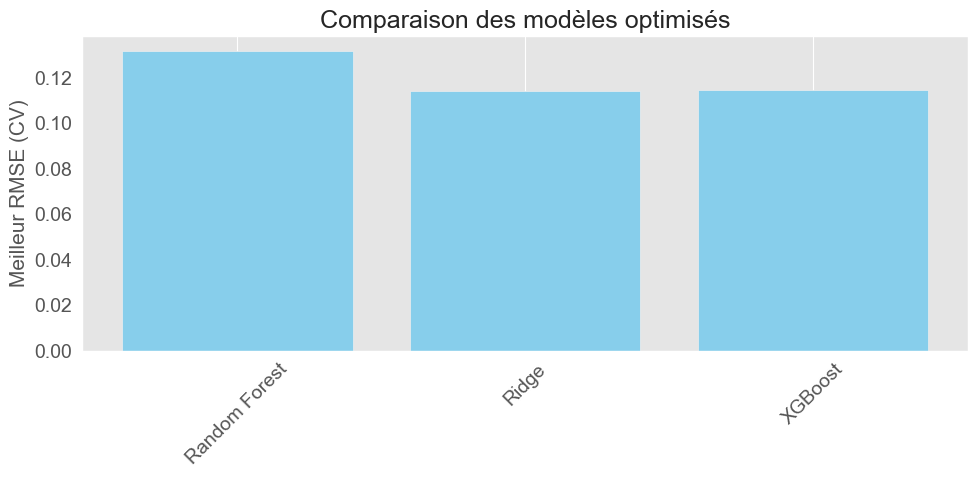

In [54]:
print("\n--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---")

model_configs = {
    'Random Forest': random_forest_objective,
    'Ridge': ridge_objective,
    'XGBoost': xgBoost_objective
}

results = optimize_models(model_configs, X_train, y_train, preprocessing_pipeline, n_trials=100)

random_forest_best_params = results['Random Forest'][1]
ridge_best_params = results['Ridge'][1]
xgboost_best_params = results['XGBoost'][1]

random_forest_study = results['Random Forest'][2]
ridge_study = results['Ridge'][2]
xgboost_study = results['XGBoost'][2]

## 4. Phase de Déploiement : Entraînement final et Prédiction

In [ ]:
## TO DO


print("\n--- Entraînement du modèle final sur l'ensemble des données d'entraînement ---")

final_model = xgb.XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_model)
])
final_pipeline.fit(X, y)
print("Entraînement terminé.")

log_predictions = final_pipeline.predict(X_test)
final_predictions = np.expm1(log_predictions)

submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_predictions})
submission.to_csv('submission_optimized.csv', index=False)

print("\nFichier 'submission_optimized.csv' généré avec succès.")
print("Aperçu des prédictions :")
print(submission.head())

In [ ]:
# 4.3 Analyse de l'Importance des Variables
ohe_feature_names = final_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('Importance des 20 Principales Variables (XGBoost Final)')
plt.show()

## Cadre juridique et éthique appliqué au projet Banklytics

### Référentiels réglementaires mobilisés
Bien que le projet soit ancré dans un contexte nord-américain, sa conception s’appuie volontairement sur les référentiels européens, en particulier le Règlement sur l’intelligence artificielle (AI Act) et le Règlement général sur la protection des données (RGPD). Cette approche permet d’anticiper les exigences internationales en matière de gouvernance algorithmique et de garantir un haut niveau de conformité, notamment en cas d’extension du modèle à d’autres juridictions.

### Gouvernance des données
Les données utilisées sont extraites d’anciens dossiers techniques de prêts hypothécaires, comprenant uniquement des caractéristiques factuelles des biens immobiliers (surface, nombre de pièces, année de construction, qualité générale, etc.). Aucune information personnelle ou sensible concernant les emprunteurs n’est incluse. L’ensemble du jeu de données est anonymisé, consolidé et nettoyé, conformément aux principes du RGPD, afin de garantir la protection des données et la qualité statistique du modèle.

### Prévention des biais et équité
Certaines variables, telles que la localisation (quartier), sont identifiées comme potentiellement sensibles en raison de leur corrélation possible avec des inégalités socio-économiques. Des analyses exploratoires ont permis de surveiller ces variables et d’anticiper d’éventuels biais indirects. Un mécanisme de monitoring post-déploiement est prévu afin de détecter toute dérive ou discrimination systématique sur des segments spécifiques (zones géographiques, types de biens).

### Explicabilité et supervision humaine
Le modèle est conçu pour fonctionner comme un outil d’aide à la décision, sans automatiser l’acceptation ou le refus d’un crédit. Chaque estimation est accompagnée d’une visualisation des facteurs explicatifs, grâce à l’outil SHAP, permettant à l’analyste de comprendre les variables ayant influencé la prédiction. Ce principe d’explicabilité répond aux exigences de l’article 13 du RGPD et aux recommandations de l’article 14 de l’AI Act sur la supervision humaine des systèmes à haut risque.

### Auditabilité et cycle de vie du modèle
Conformément aux articles 9 à 15 de l’AI Act, le modèle fait l’objet d’une documentation rigoureuse, incluant la version des jeux de données, les hyperparamètres d’apprentissage, les performances historiques (RMSLE), ainsi que les résultats des tests de robustesse. Un retraining trimestriel est prévu avec les nouvelles données validées, accompagné d’un suivi mensuel des performances pour détecter d’éventuelles dérives (concept drift).

## Conclusion

Ce notebook a appliqué une démarche robuste et moderne :

1. Utilisation d'un pipeline Scikit-Learn pour un prétraitement propre et reproductible.
2. Optimisation automatisée des hyperparamètres avec Optuna pour maximiser la performance.
3. Entraînement d'un modèle final performant et génération des prédictions.
4. Analyse de l'importance des variables pour une meilleure explicabilité du modèle.

Le modèle est prêt à être intégré comme outil d'aide à la décision pour les analystes de Banklytics.